# ING Lion's Den 2024

## Team: RiskBusters


 Michał Bryzik, Michał Niegierewicz, Kacper Gruca, Jan Ślusarek
 

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score,average_precision_score, recall_score, f1_score,precision_recall_curve, auc, classification_report, confusion_matrix, make_scorer, fbeta_score
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import resample
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from scipy import stats
import statsmodels.tools as sm_tools
import statsmodels.stats.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit
from statsmodels.tools import add_constant
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import BaggingClassifier



In [15]:
df_train=pd.read_csv('../data/output/categorical_dfs/development_sample_woe.csv')
df_test=pd.read_csv('../data/output/categorical_dfs/testing_sample_woe.csv')

# Creating basic model for WOE data


Optimization terminated successfully.
         Current function value: 0.116173
         Iterations 9


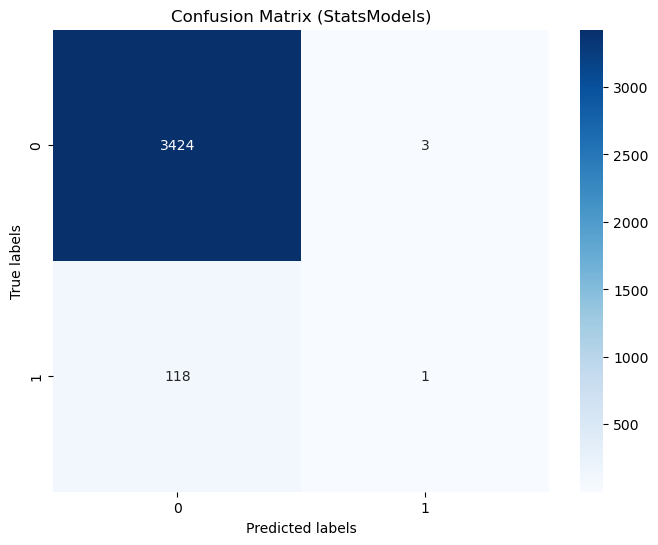

In [16]:
import statsmodels.api as sm

X_train = df_train.drop('target', axis=1)
y_train = df_train['target']
X_test = df_test.drop('target', axis=1)
y_test = df_test['target']
# Przygotowanie danych
X_train_sm = sm.add_constant(X_train)  # Dodanie kolumny stałej
y_train_sm = y_train

# Budowa modelu regresji logistycznej
model_sm = sm.Logit(y_train_sm, X_train_sm).fit()

# Przewidywanie prawdopodobieństw dla danych testowych
X_test_sm = sm.add_constant(X_test)  # Uwzględnienie stałej w danych testowych
y_pred_prob_sm = model_sm.predict(X_test_sm)

# Zamiana prawdopodobieństw na etykiety klasy na podstawie domyślnego progu 0.5
y_pred_sm = (y_pred_prob_sm >= 0.5).astype(int)

# Generowanie macierzy pomyłek
conf_matrix_sm = confusion_matrix(y_test, y_pred_sm)

# Wizualizacja macierzy pomyłek
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_sm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix (StatsModels)')
plt.show()


Basic logit model has weak forecasting features, as we could see in the confusion matrix above. In the next stage we will want to manipulate the parameters of this model to improve accuracy of the prediction. 

In [17]:
# Dopasowanie modelu i wyświetlenie podsumowania
model_summary = model_sm.summary()
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                35700
Model:                          Logit   Df Residuals:                    35681
Method:                           MLE   Df Model:                           18
Date:                Thu, 14 Mar 2024   Pseudo R-squ.:                  0.1560
Time:                        19:46:29   Log-Likelihood:                -4147.4
converged:                       True   LL-Null:                       -4914.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   12.6964      0.565     22.458      0.000      11.588      13.804
Var11_woe               -1.2523      0.101    -12.363      0.000      -1.451      -1.054
Var12_woe               -1.5831      0.196     -8.086      0.000      -1.967      -1.199
Var14_woe               -1.0506      0.130     -8.070      0.000      -1.306      -0.795
Var17_1_woe             -2.3608      0.192    -12.288      0.000      -2.737      -1.984
Var25_q_woe             -1.1387      0.140     -8.116      0.000      -1.414      -0.864
Var26_q_woe             -0.7430      0.105     -7.052      0.000      -0.949      -0.536
Var27_woe               -0.3479      0.182     -1.907      0.056      -0.705       0.010
Var28_woe               -1.6745      0.104    -16.148      0.000      -1.878      -1.471
Var29_woe               -1.2566      0.128     -9.851      0.000      -1.507      -1.007
Var3_woe                 0.0354      0.275      0.129      0.898      -0.504       0.575
Var4_woe                 0.2573      0.241      1.066      0.286      -0.216       0.730
Var5_woe                -0.6376      0.270     -2.361      0.018      -1.167      -0.108
Var8_q_woe              -0.5178      0.180     -2.884      0.004      -0.870      -0.166
idi_ratio_woe           -0.7453      0.098     -7.575      0.000      -0.938      -0.552
ii_ratio_woe            -0.3597      0.156     -2.302      0.021      -0.666      -0.053
income_woe              -0.9192      0.139     -6.630      0.000      -1.191      -0.647
loan_desc_woe           -0.7981      0.116     -6.910      0.000      -1.024      -0.572
working_months_1_woe    -0.2858      0.140     -2.038      0.042      -0.561      -0.011
========================================================================================
"""

The logistic regression model was fitted to the data using Maximum Likelihood Estimation (MLE), aiming to model the relationship between the binary outcome variable "target" and a set of predictor variables. The dataset consists of 35,700 observations, enabling robust statistical inference.

The pseudo R-squared of 0.1560 suggests that approximately 15.6% of the variance in the outcome variable is explained by the predictor variables. The log-likelihood value of -4147.4 indicates a significant improvement over the null model (LL-Null: -4914.1), supported by an associated LLR p-value of 0.000. These results signify the superiority of the applied model in explaining the outcome compared to a model with no predictor variables.

Analyzing the coefficients provides insights into the impact of individual predictor variables on the outcome variable. The intercept, or the intercept, is estimated at 12.6964, representing the baseline log-odds when all predictor variables are equal to zero. Statistically significant effects are observed for variables such as Var11_woe, Var12_woe, Var14_woe, Var17_1_woe, etc., with coefficients having p-values < 0.05. Variable Var28_woe stands out with a particularly strong negative association with the outcome variable, evidenced by a coefficient of -1.6745.

Each coefficient represents the change in the log-odds of the outcome variable associated with a one-unit change in the corresponding predictor variable, assuming all other variables remain constant. For example, a one-unit increase in Var11_woe corresponds to a decrease of 1.2523 in the log-odds of the outcome variable, holding all other variables constant.

In conclusion, the logistic regression model provides valuable insights into the relationships between predictor variables and the likelihood of the outcome variable. Despite demonstrating satisfactory fit and statistical significance of coefficients, further validation and exploration of model assumptions and predictive performance may be necessary to ensure its reliability and generalizability in practice.

In [18]:
# Obliczanie przewidywanych etykiet dla zbioru uczącego na podstawie domyślnego progu 0.5
y_pred_train_sm = (model_sm.predict(X_train_sm) >= 0.5).astype(int)

# Obliczanie metryk dla zbioru uczącego
accuracy_train = accuracy_score(y_train_sm, y_pred_train_sm)
precision_train = precision_score(y_train_sm, y_pred_train_sm)
recall_train = recall_score(y_train_sm, y_pred_train_sm)
f1_train = f1_score(y_train_sm, y_pred_train_sm)

# Obliczanie metryk dla zbioru testowego
accuracy_test = accuracy_score(y_test, y_pred_sm)
precision_test = precision_score(y_test, y_pred_sm)
recall_test = recall_score(y_test, y_pred_sm)
f1_test = f1_score(y_test, y_pred_sm)

(accuracy_train, precision_train, recall_train, f1_train, accuracy_test, precision_test, recall_test, f1_test)

(0.9699159663865546,
 0.6708860759493671,
 0.048138056312443236,
 0.08983050847457627,
 0.9658770445572477,
 0.25,
 0.008403361344537815,
 0.016260162601626015)

Accuracy: High accuracy on the training set (0.9699) and the test set (0.9659) suggests that the model correctly classifies the majority of cases. However, it's worth noting that accuracy alone may not be sufficient to evaluate the model, especially when classes in the dataset are imbalanced.

Precision: Precision on the training set (0.6709) and the test set (0.25) measures how many of the positive predictions made by the model are actually correct. High precision indicates that the model rarely makes False Positive errors.

Recall: Low recall on the training set (0.0481) and the test set (0.0084) suggests that the model struggles to identify true positive cases. This means that many positive cases are being missed by the model.

F1 Score: Low F1 score on the training set (0.0898) and the test set (0.0163) indicates an unbalanced performance of the model, with a low balance between precision and recall.

1. There is no colinearity between variables 
2. Logit of probability depends for linear combination of independent variables

In [19]:

# Obliczenie VIF
VIF_data = pd.DataFrame()
VIF_data["variable"] = X_train.columns
VIF_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
print(VIF_data)


                variable         VIF
0              Var11_woe    9.452256
1              Var12_woe   48.074500
2              Var14_woe   18.570537
3            Var17_1_woe   31.624024
4            Var25_q_woe   16.839189
5            Var26_q_woe    5.575662
6              Var27_woe  124.086942
7              Var28_woe   44.664399
8              Var29_woe   28.330658
9               Var3_woe   89.612623
10              Var4_woe   66.119336
11              Var5_woe   77.518278
12            Var8_q_woe   23.205567
13         idi_ratio_woe   16.949063
14          ii_ratio_woe   28.755720
15            income_woe   17.280532
16         loan_desc_woe   15.164641
17  working_months_1_woe   24.588123



Here's the translation of the VIF interpretation into English:

VIF = 1: No correlation between the variable and other variables.
1 < VIF < 5: Moderate correlation, usually not a problem.
VIF >= 5: High correlation, worth investigating as it may indicate an issue with multicollinearity.
VIF >= 10: Indicates very high correlation and serious problems with multicollinearity, which can distort regression analysis.

Var11_woe: VIF = 9.452256 - Indicates a moderate level of correlation with other variables.

Var12_woe: VIF = 48.074500 - Indicates a high level of correlation, potentially indicating multicollinearity issues.

Var14_woe: VIF = 18.570537 - Indicates a moderate level of correlation with other variables.

Var17_1_woe: VIF = 31.624024 - Indicates a high level of correlation, potentially indicating multicollinearity issues.

Var25_q_woe: VIF = 16.839189 - Indicates a moderate level of correlation with other variables.

Var26_q_woe: VIF = 5.575662 - Indicates a moderate level of correlation with other variables.

Var27_woe: VIF = 124.086942 - Indicates a very high level of correlation and serious problems with multicollinearity.

Var28_woe: VIF = 44.664399 - Indicates a high level of correlation, potentially indicating multicollinearity issues.

Var29_woe: VIF = 28.330658 - Indicates a high level of correlation, potentially indicating multicollinearity issues.

Var3_woe: VIF = 89.612623 - Indicates a very high level of correlation and serious problems with multicollinearity.

Var4_woe: VIF = 66.119336 - Indicates a very high level of correlation and serious problems with multicollinearity.

Var5_woe: VIF = 77.518278 - Indicates a very high level of correlation and serious problems with multicollinearity.

Var8_q_woe: VIF = 23.205567 - Indicates a high level of correlation, potentially indicating multicollinearity issues.

idi_ratio_woe: VIF = 16.949063 - Indicates a moderate level of correlation with other variables.

ii_ratio_woe: VIF = 28.755720 - Indicates a high level of correlation, potentially indicating multicollinearity issues.

income_woe: VIF = 17.280532 - Indicates a moderate level of correlation with other variables.

loan_desc_woe: VIF = 15.164641 - Indicates a moderate level of correlation with other variables.

working_months_1_woe: VIF = 24.588123 - Indicates a high level of correlation, potentially indicating multicollinearity issues.

# Modify threshold parameter for logit model

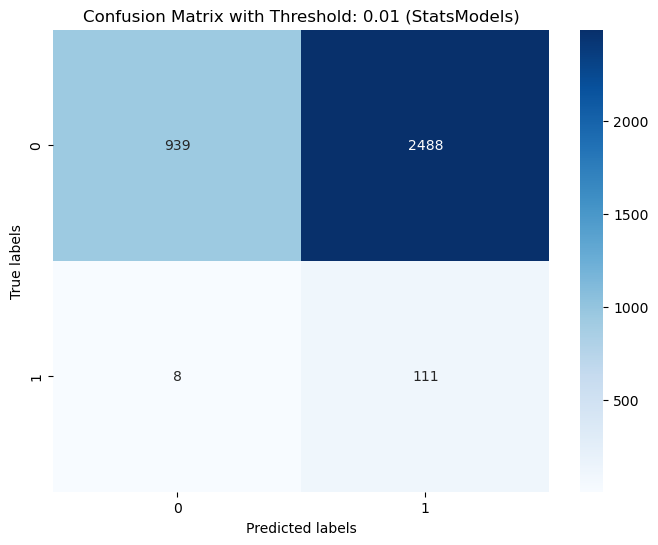

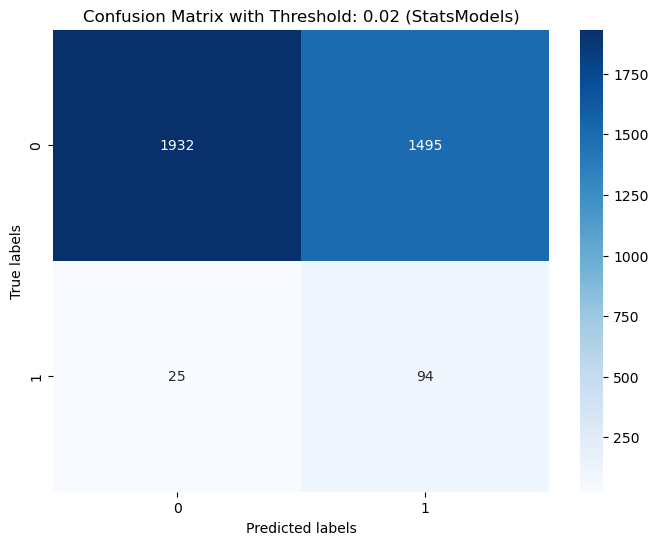

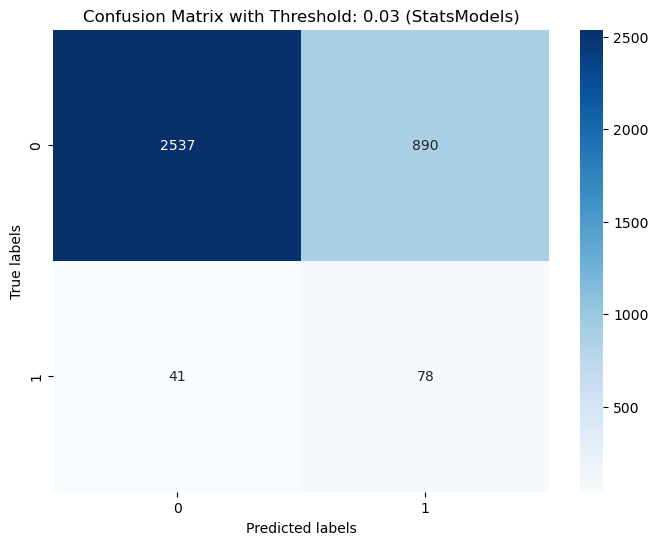

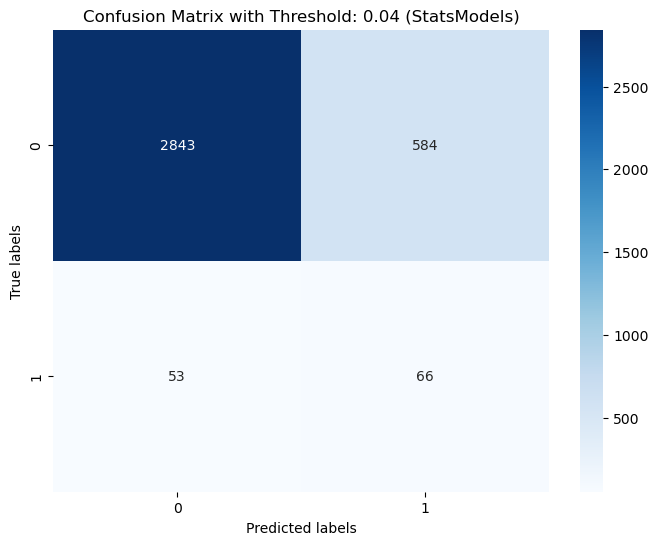

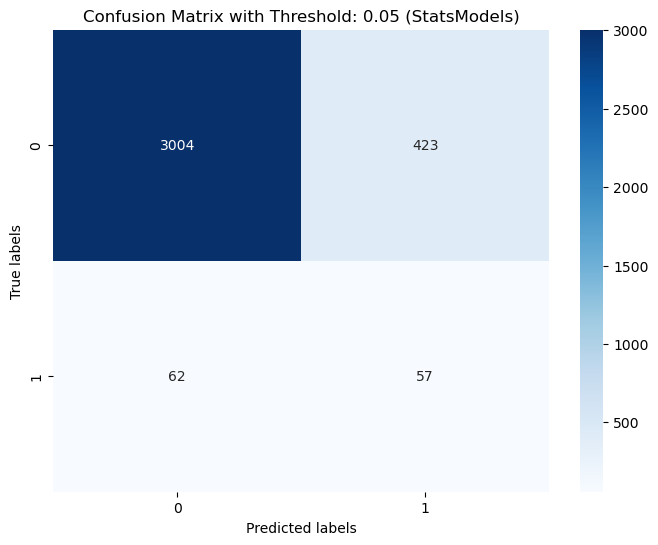

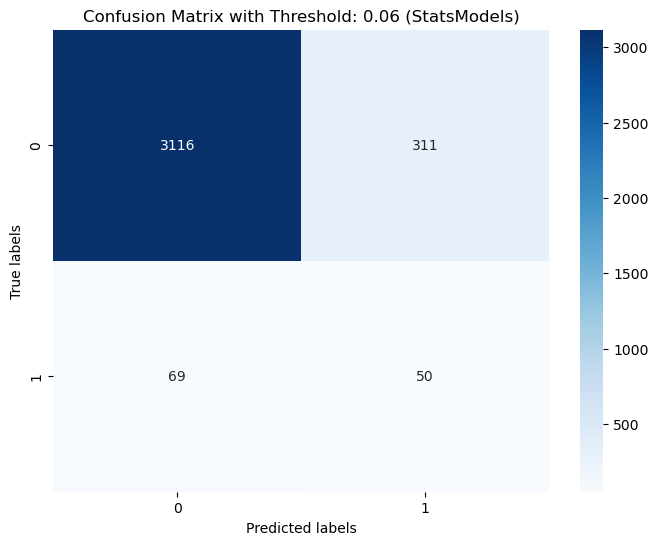

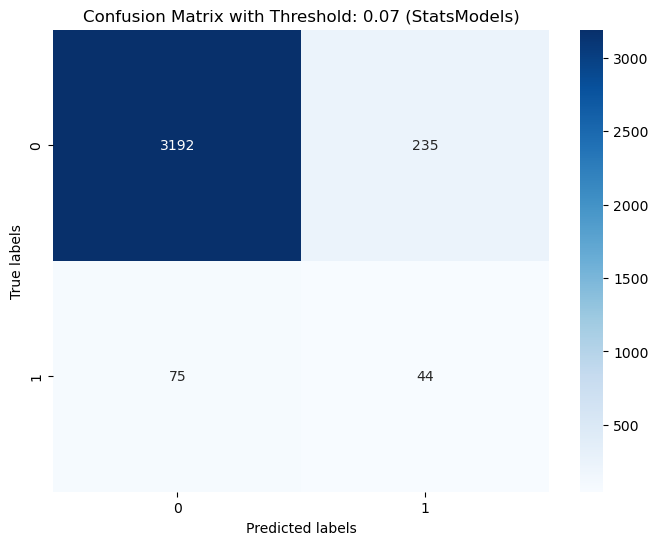

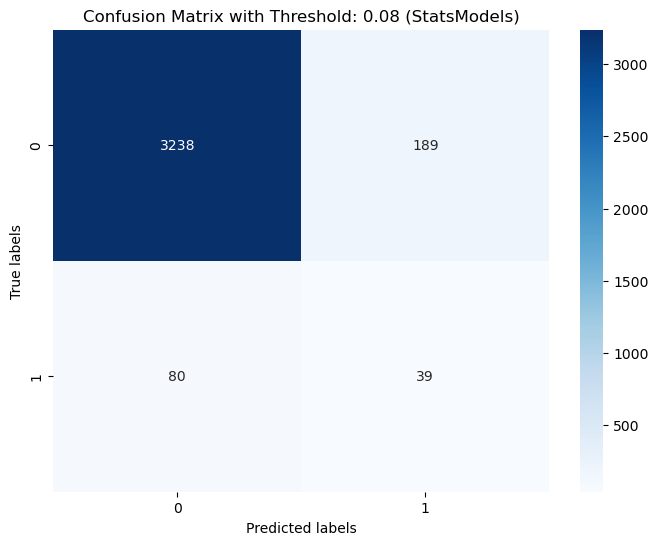

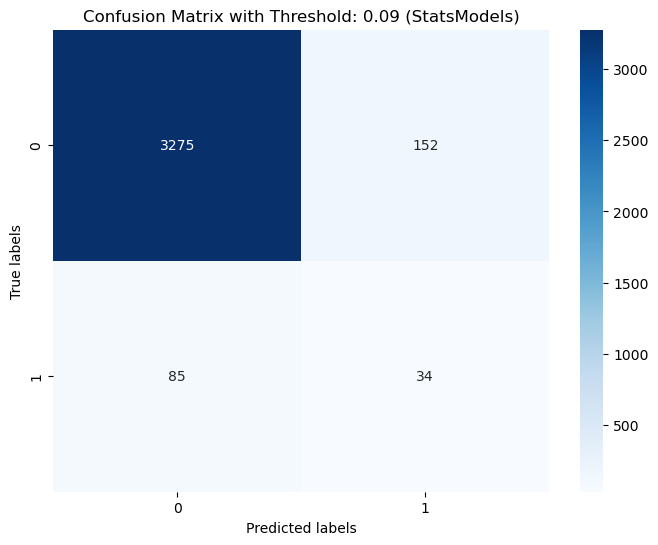

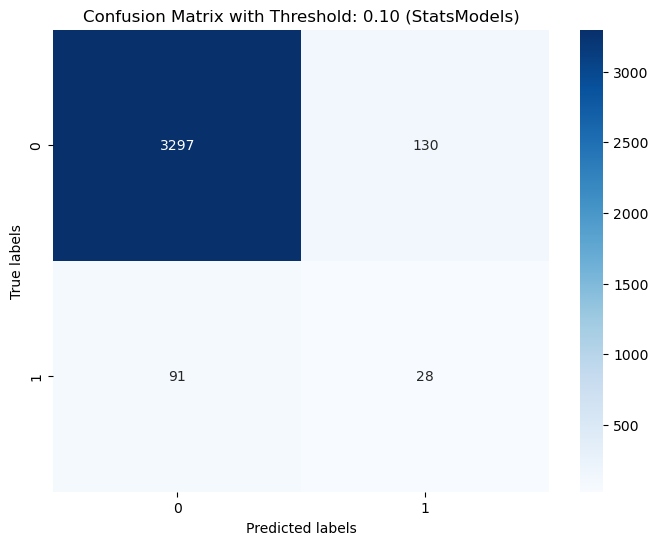

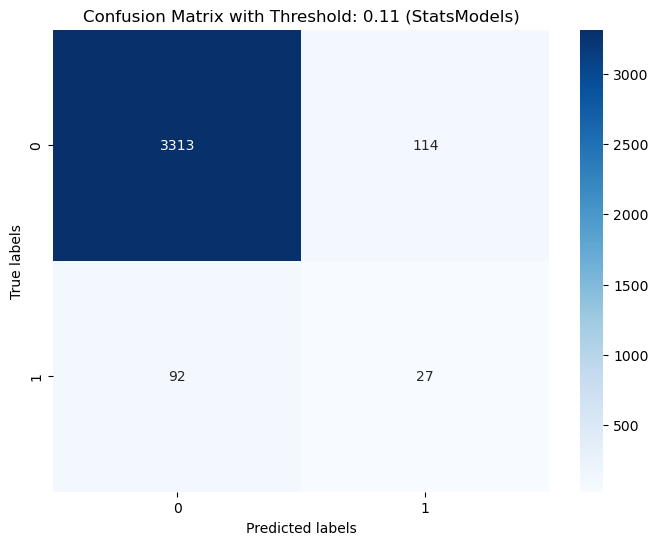

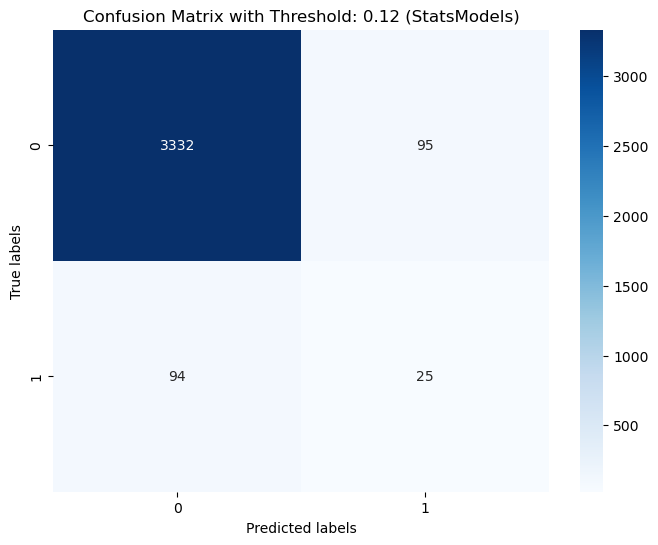

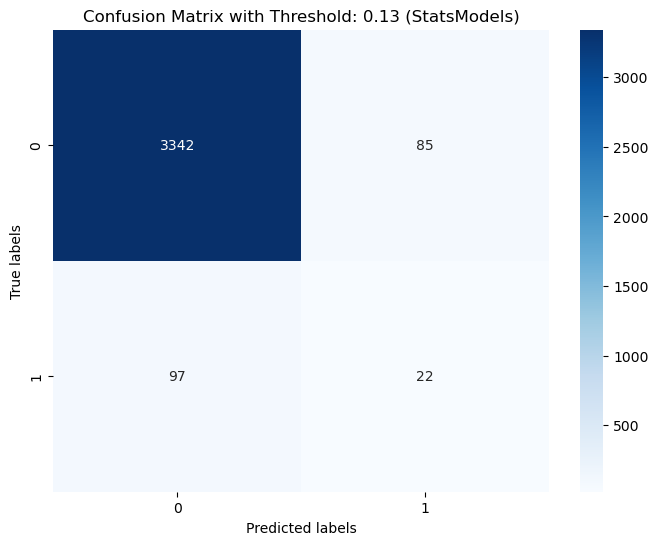

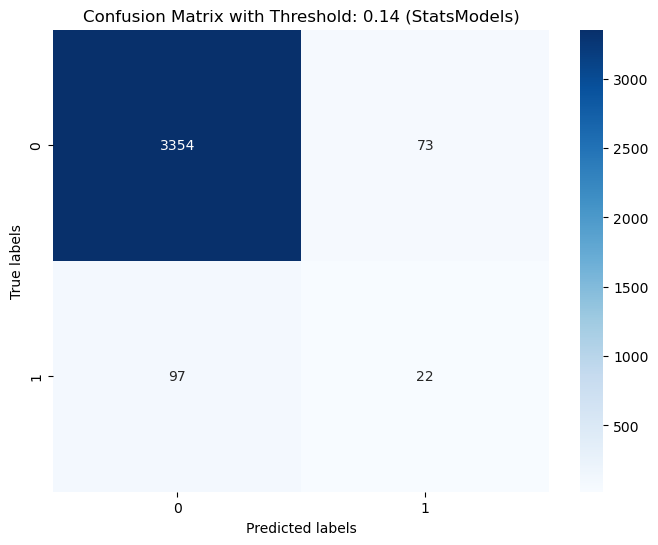

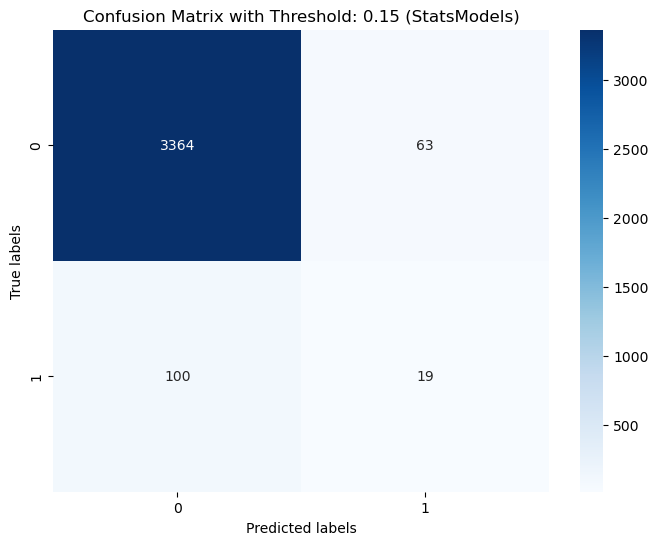

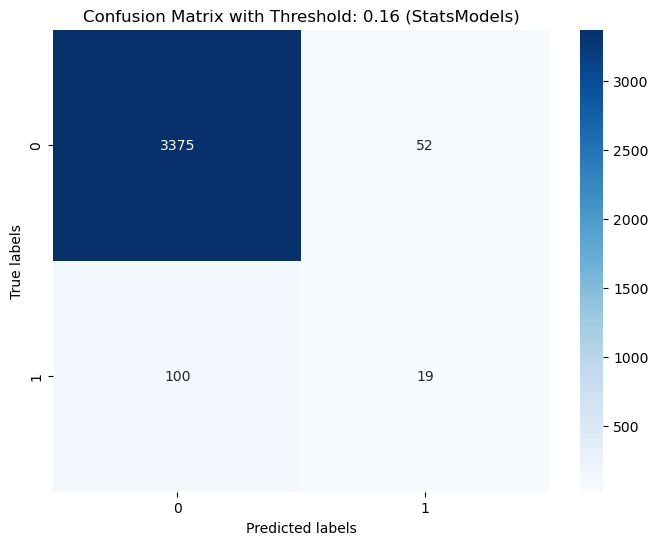

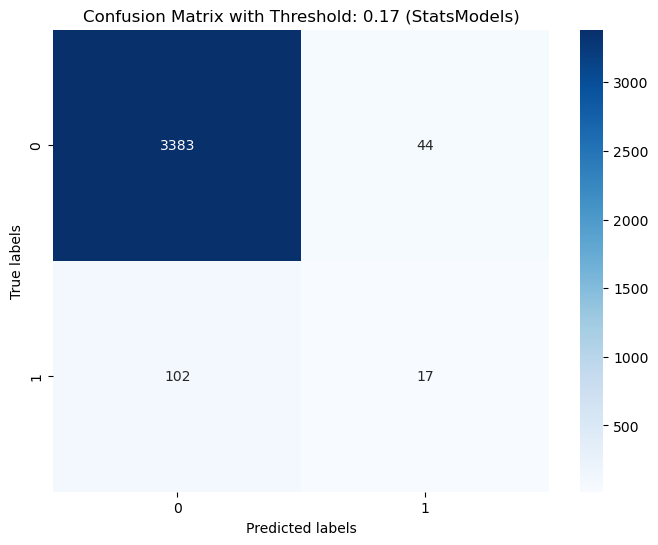

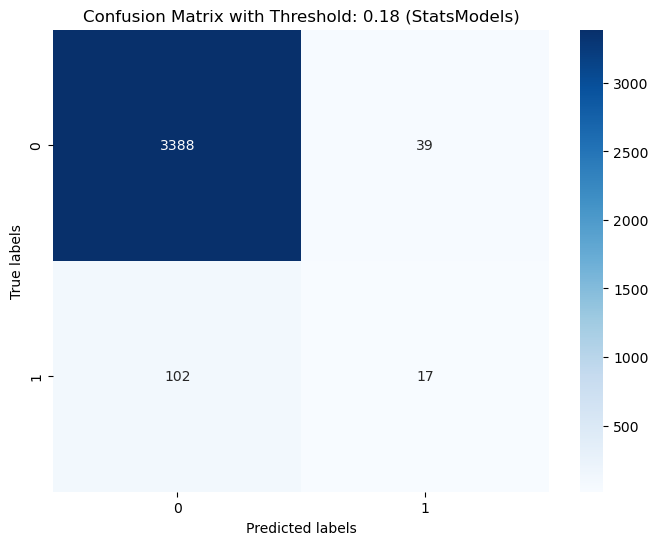

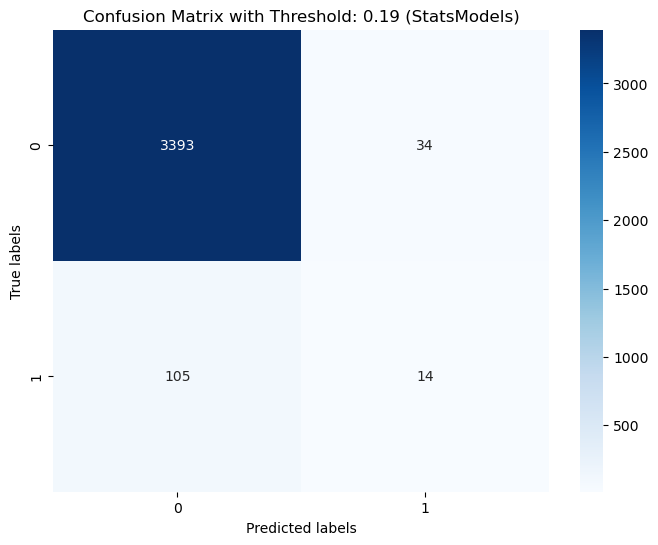

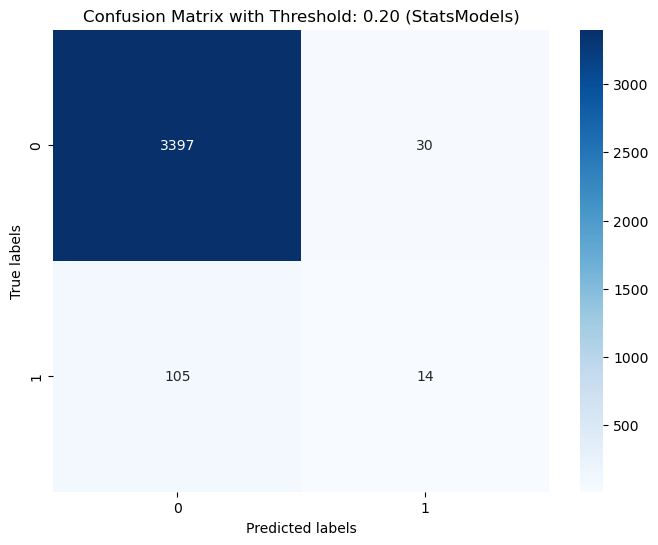

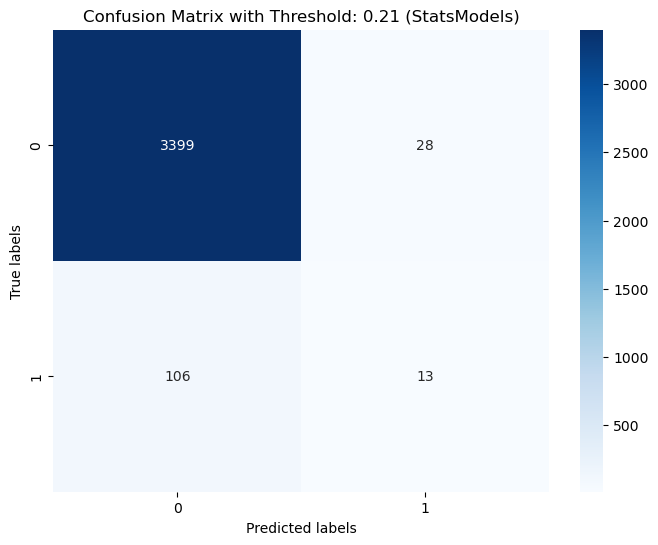

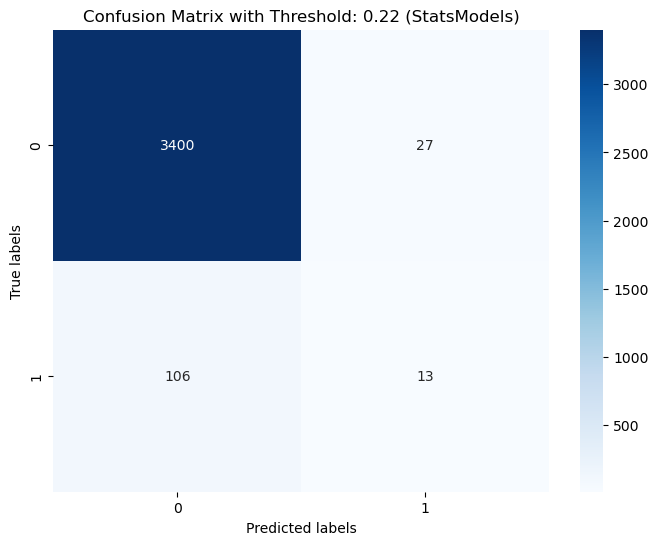

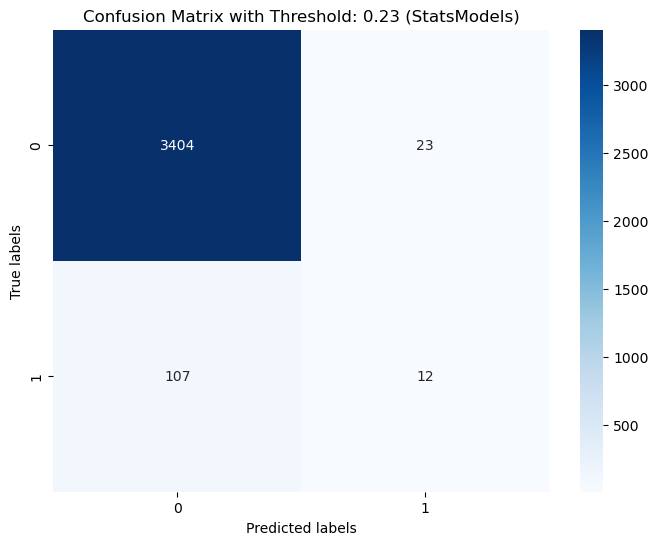

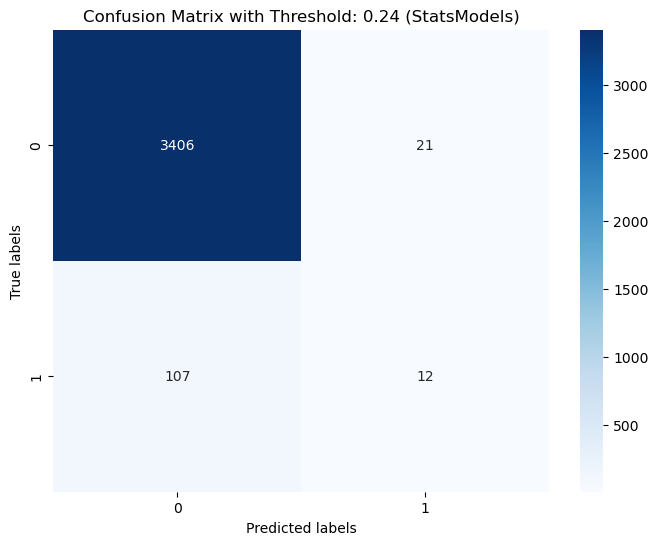

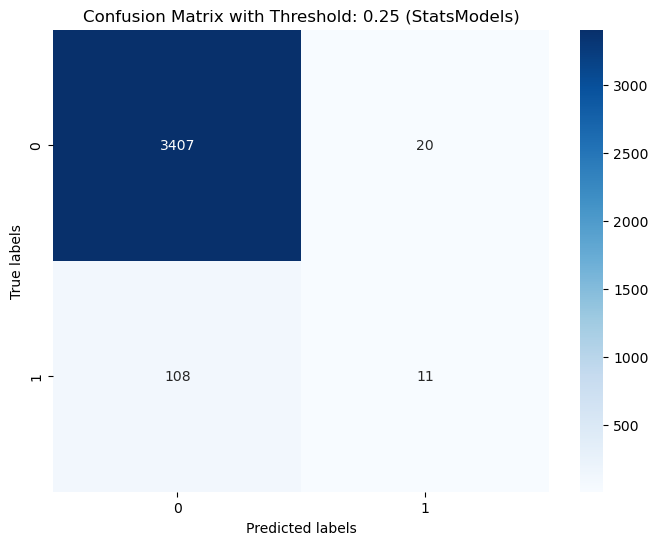

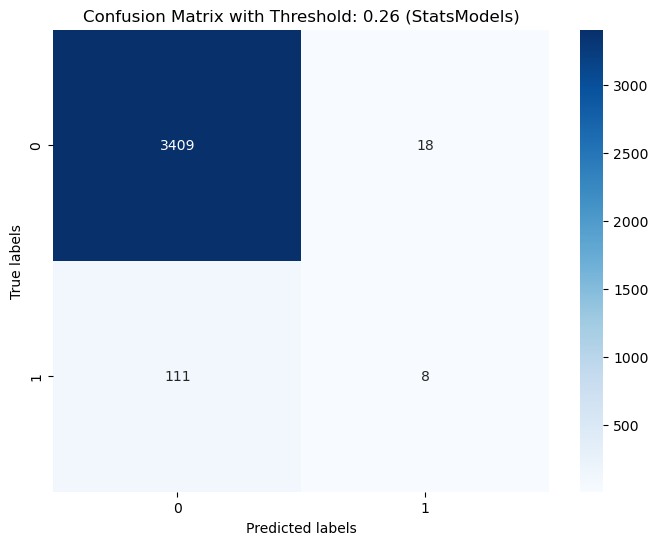

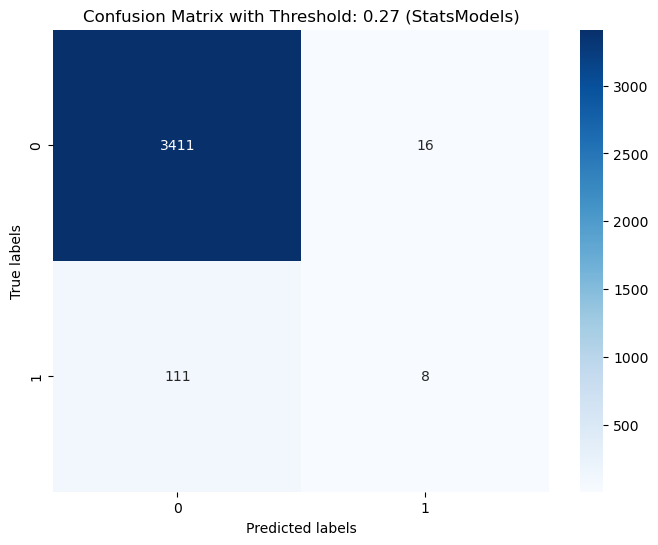

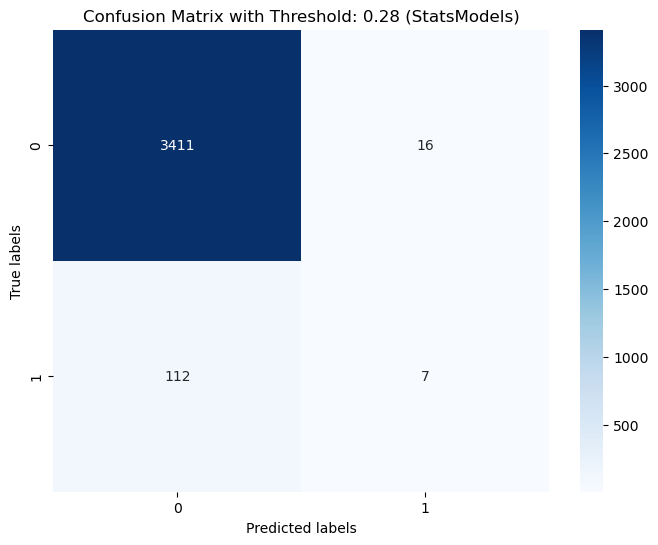

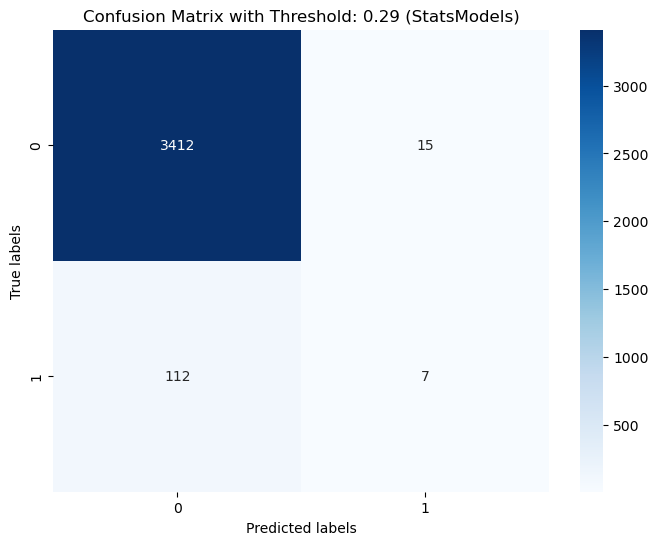

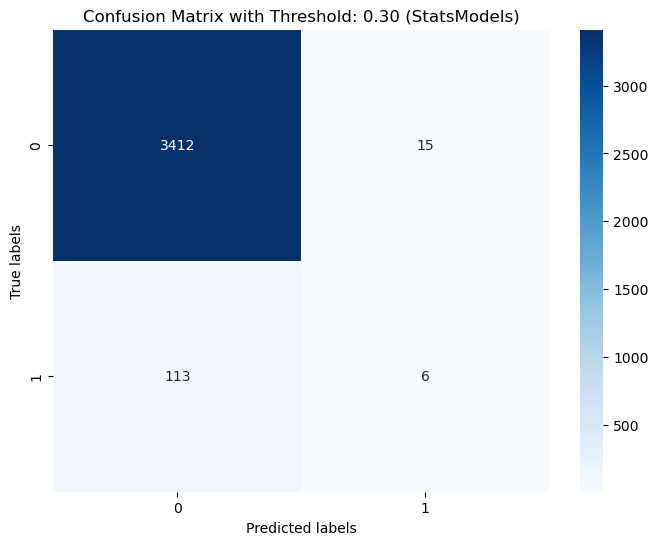

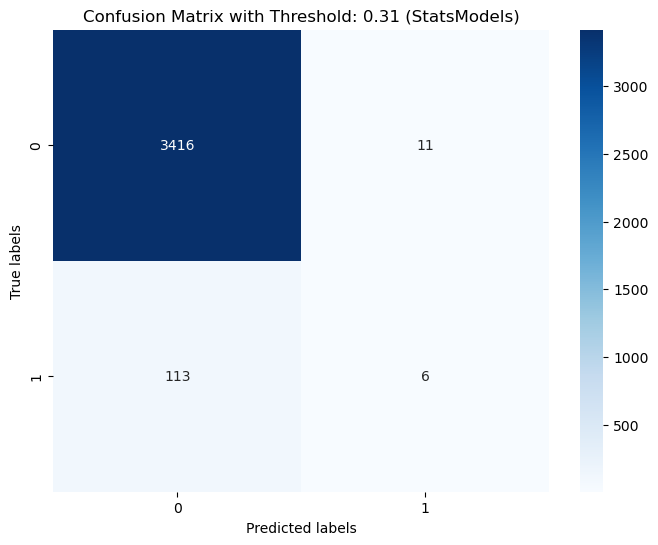

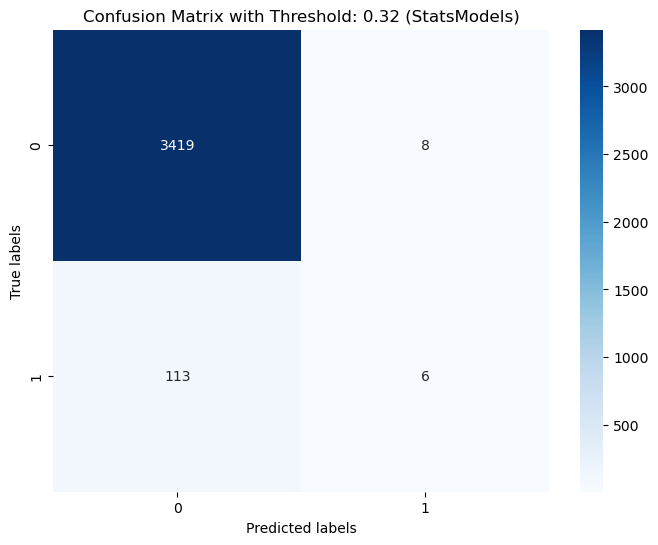

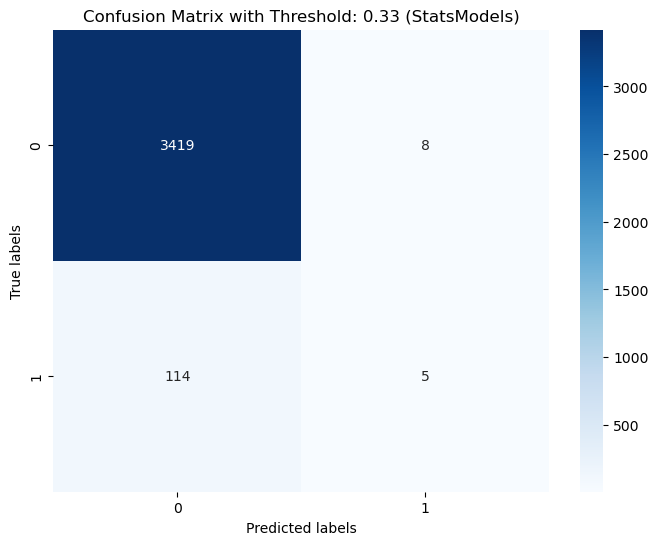

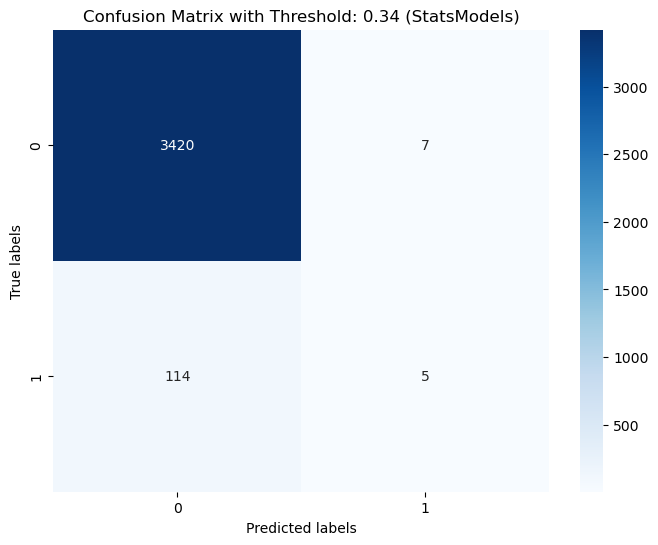

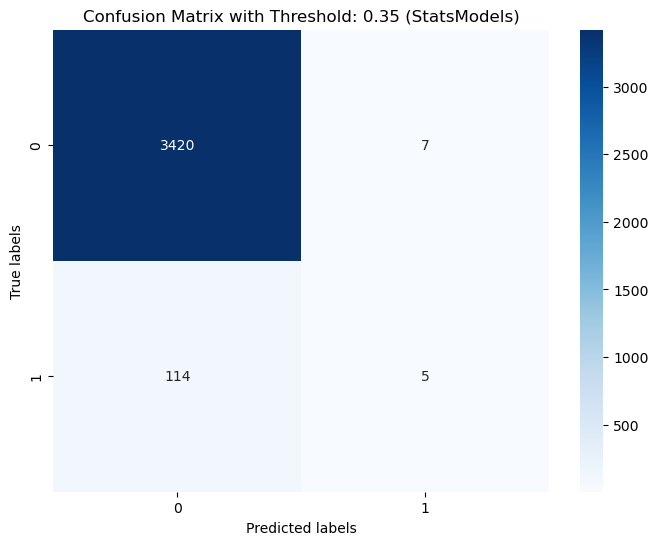

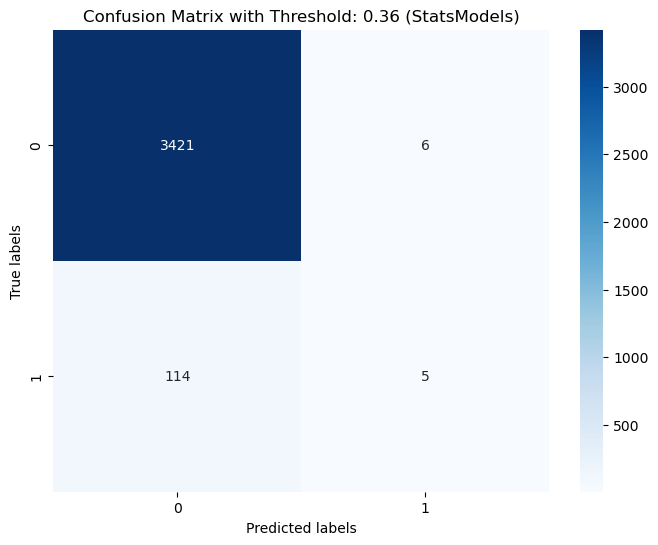

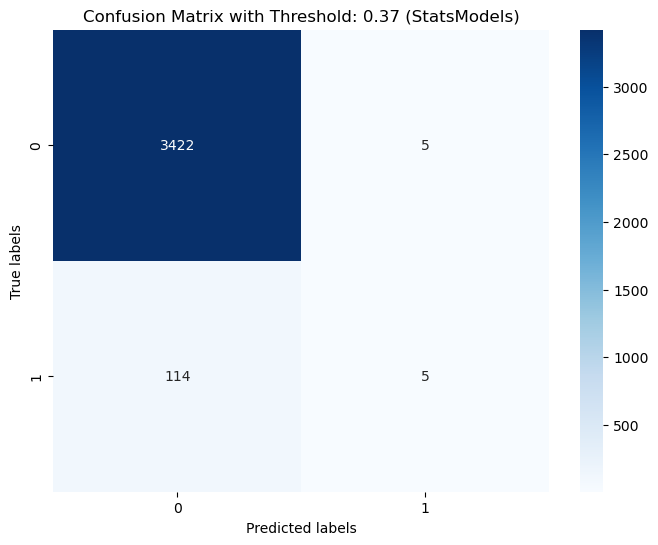

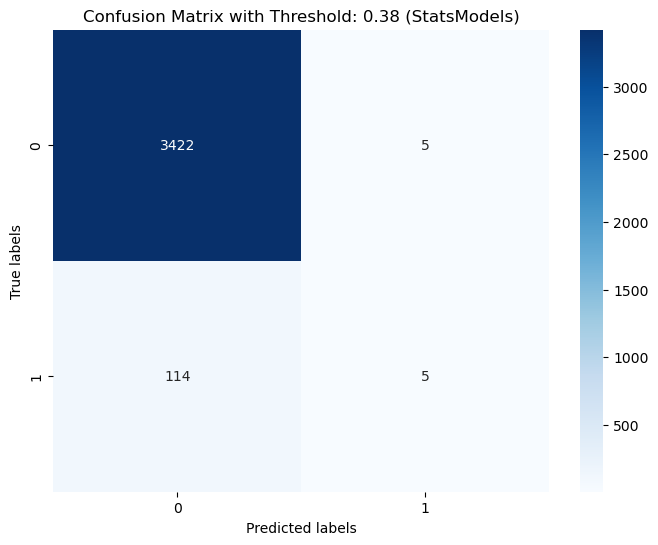

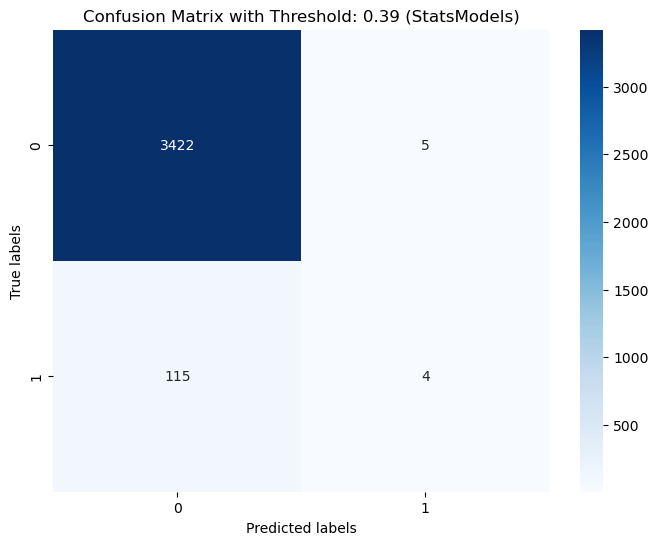

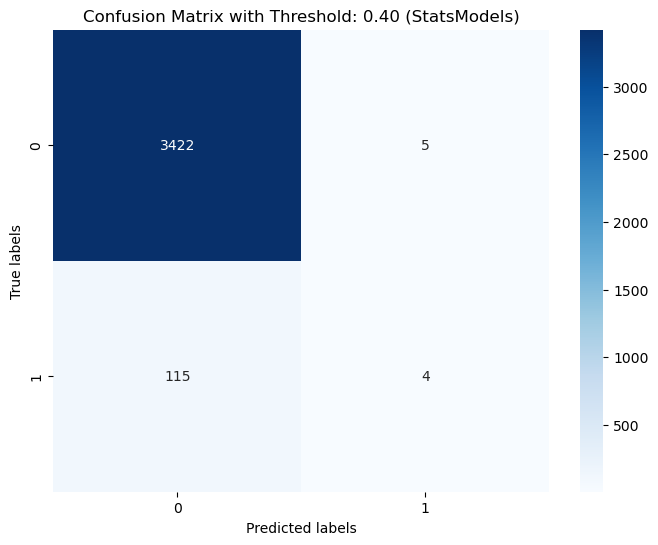

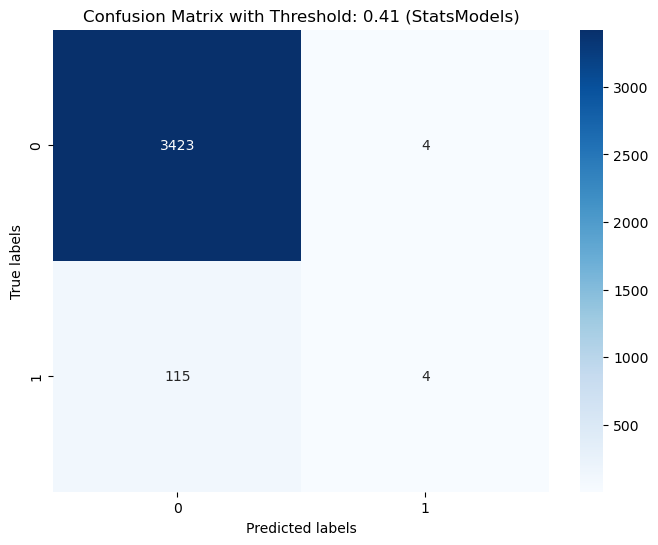

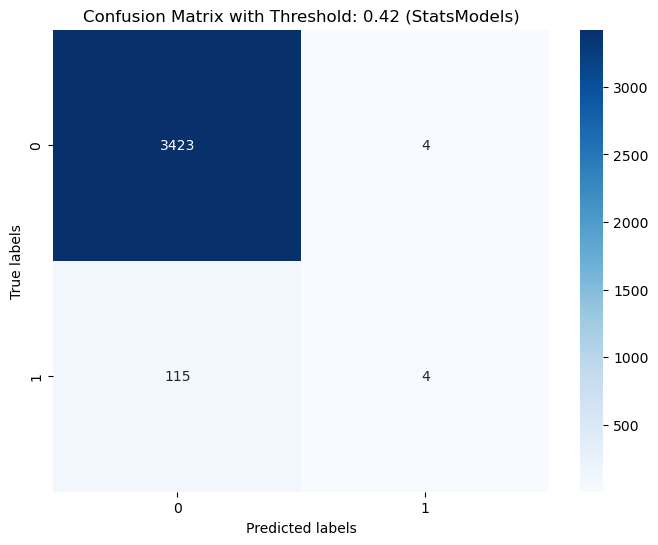

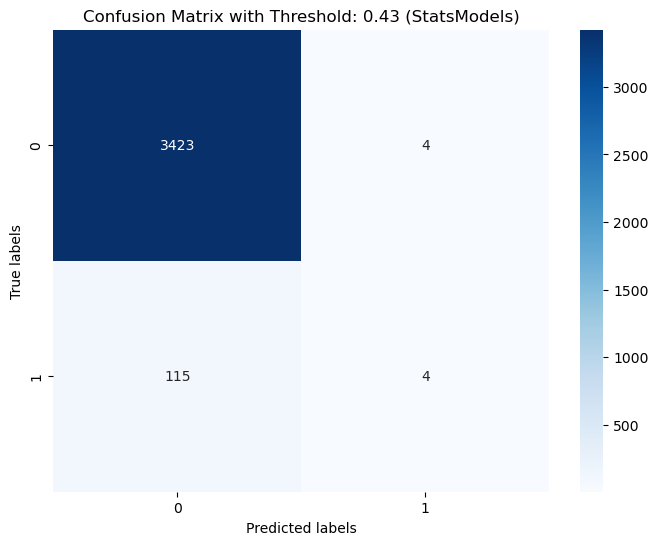

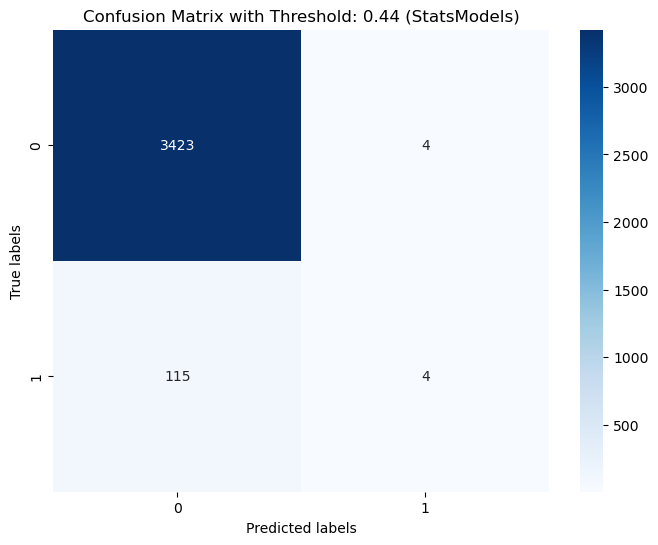

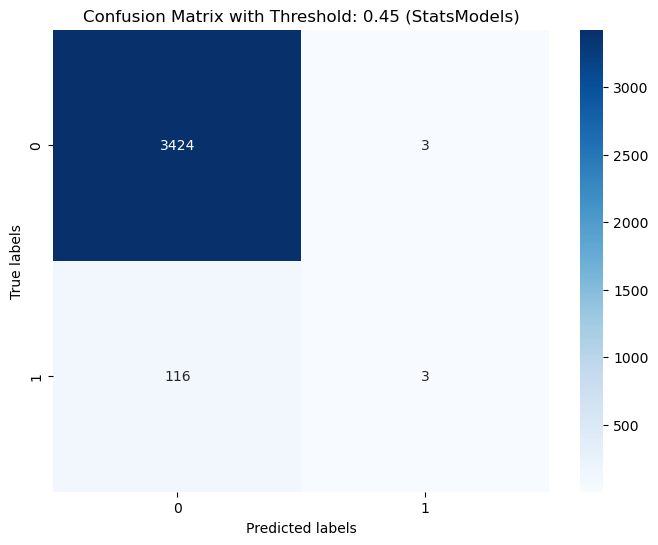

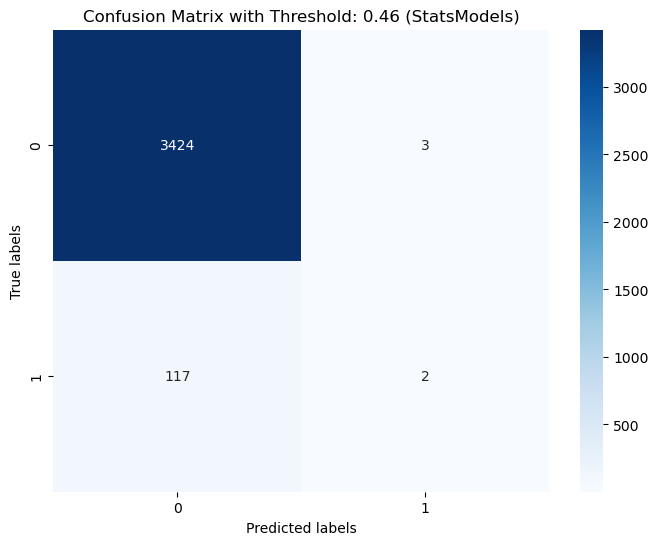

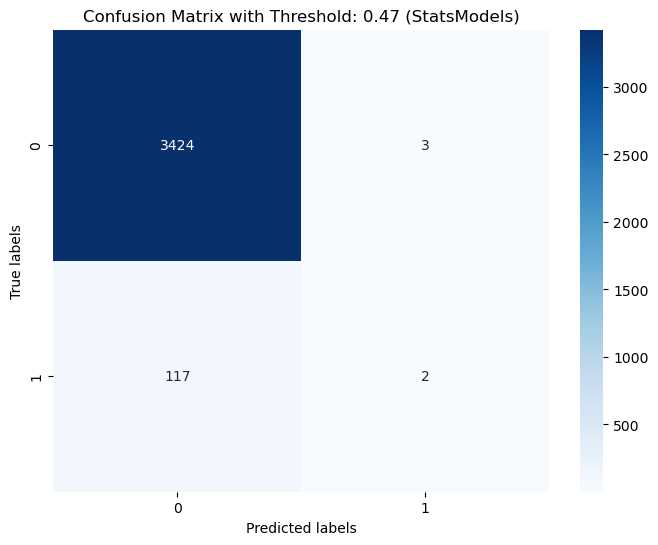

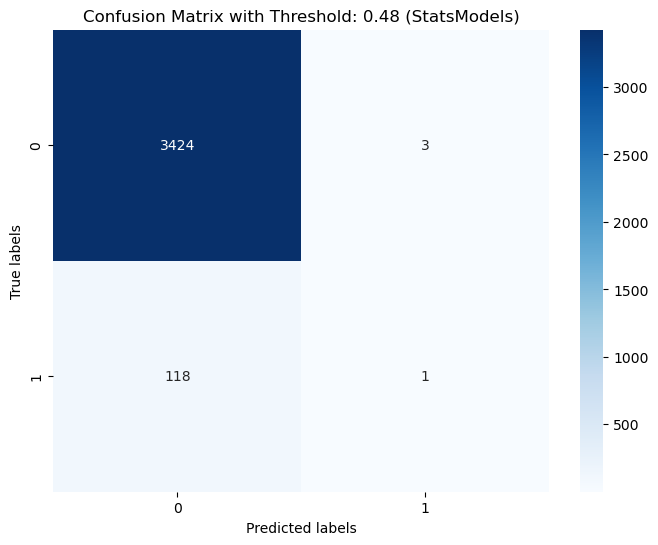

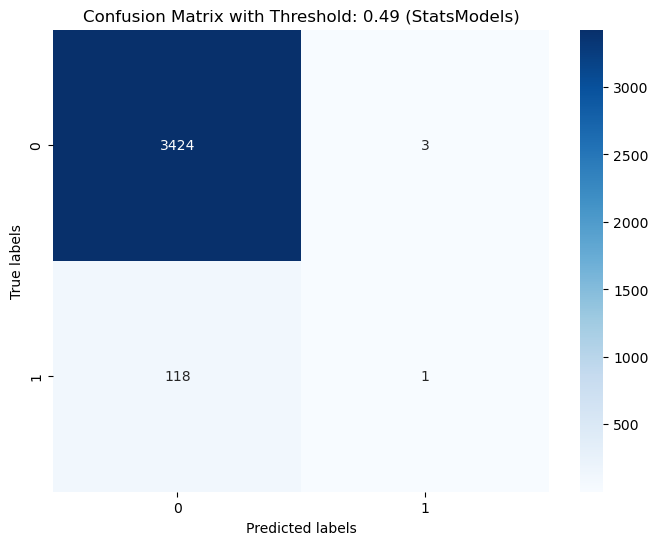

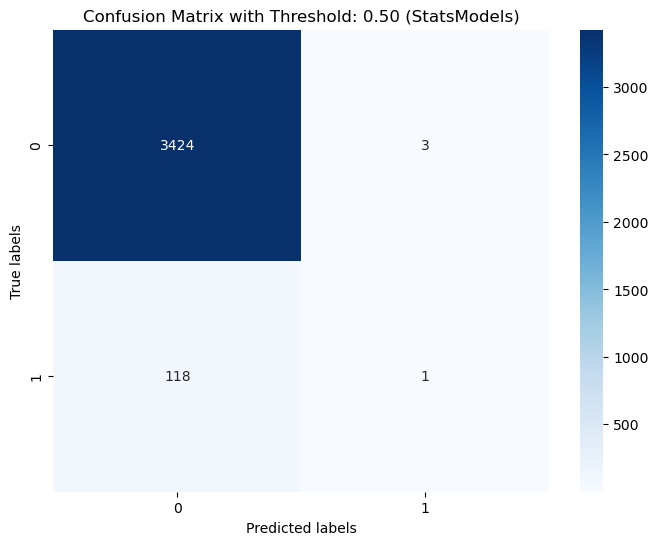

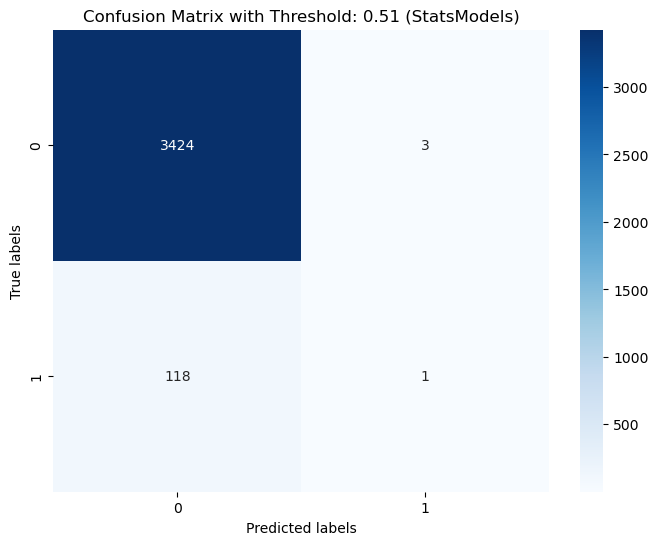

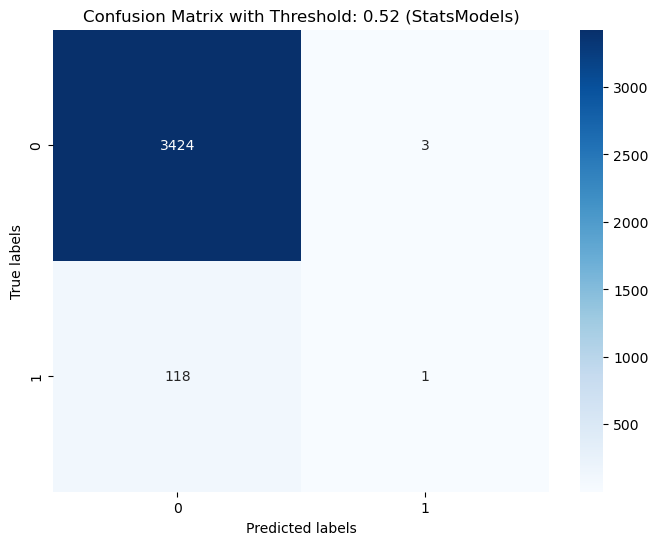

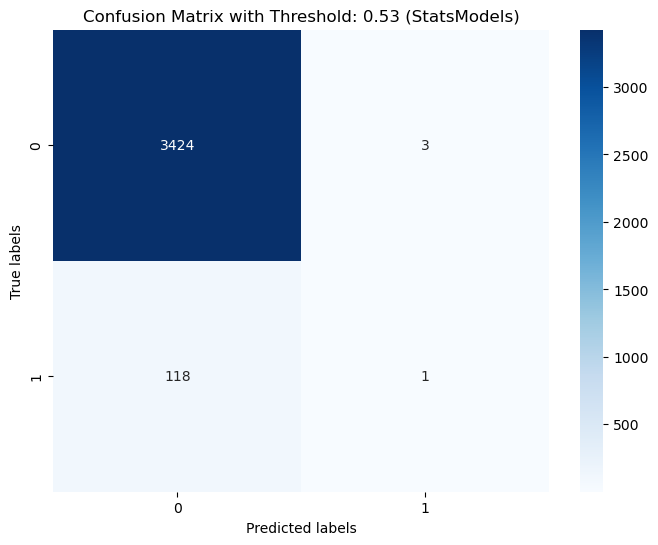

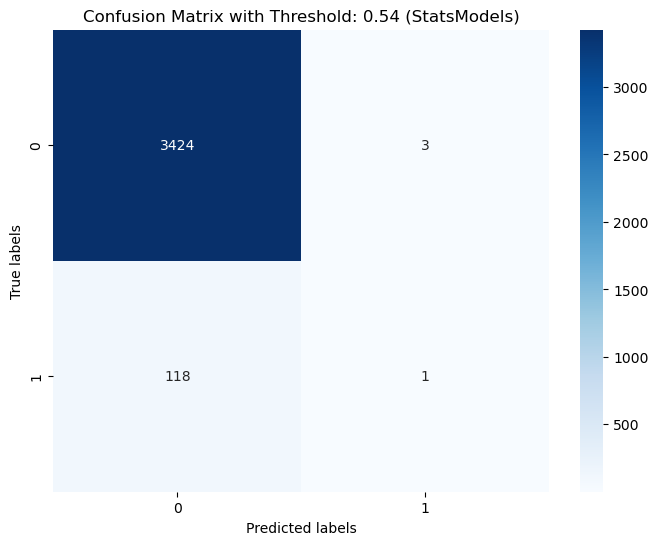

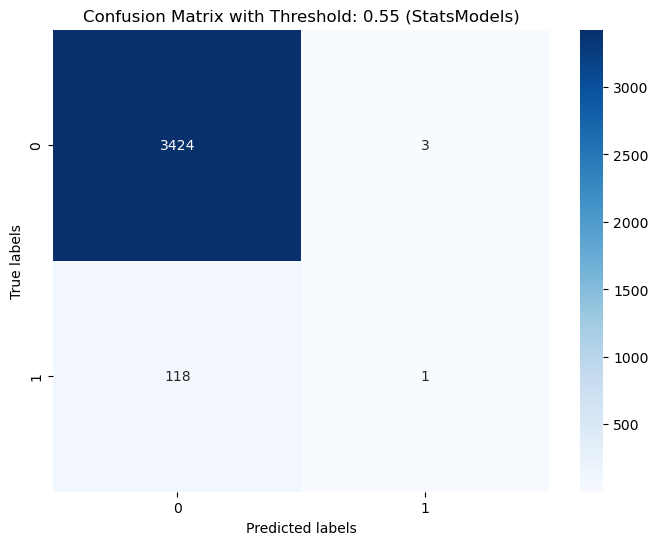

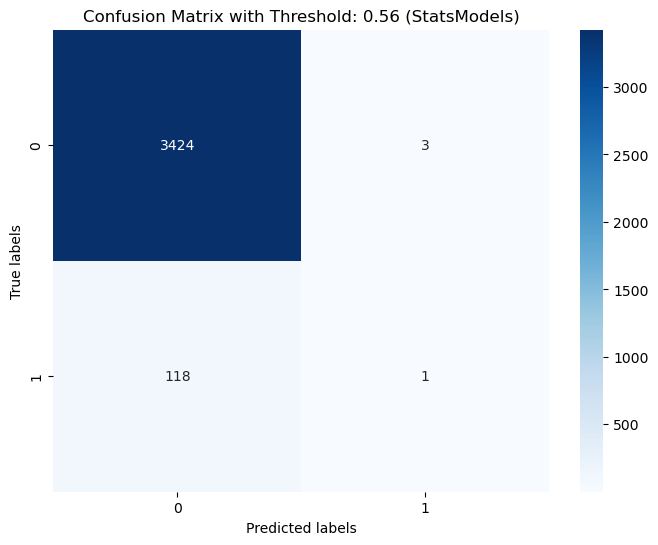

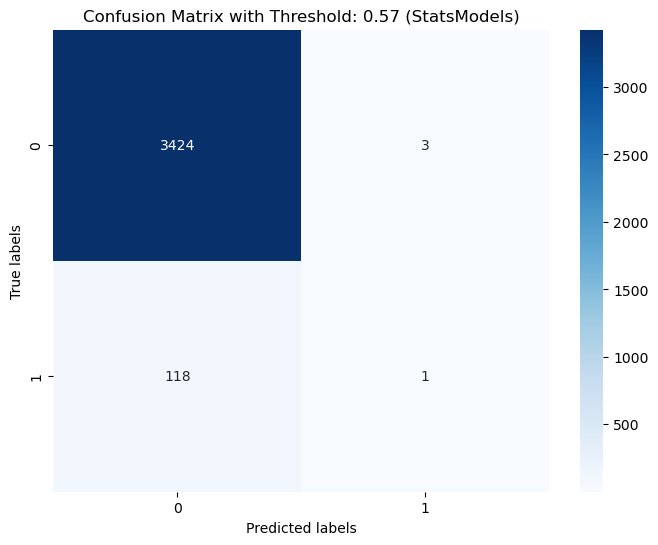

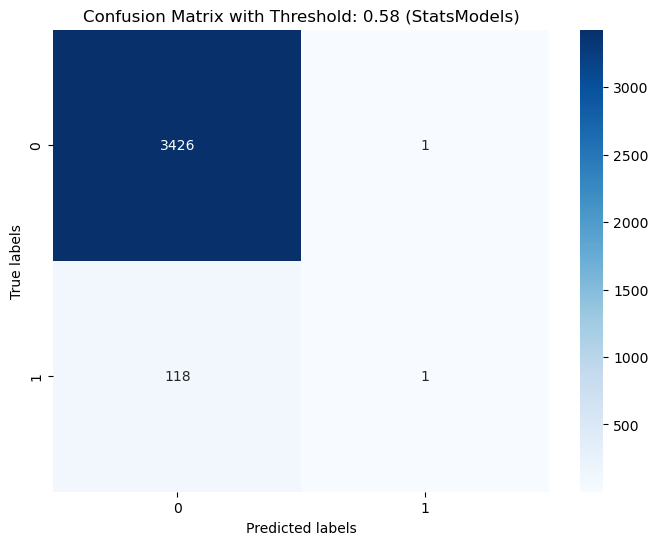

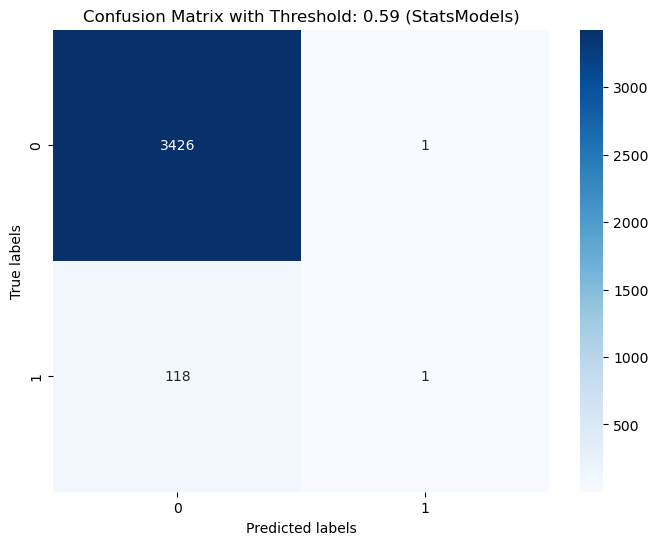

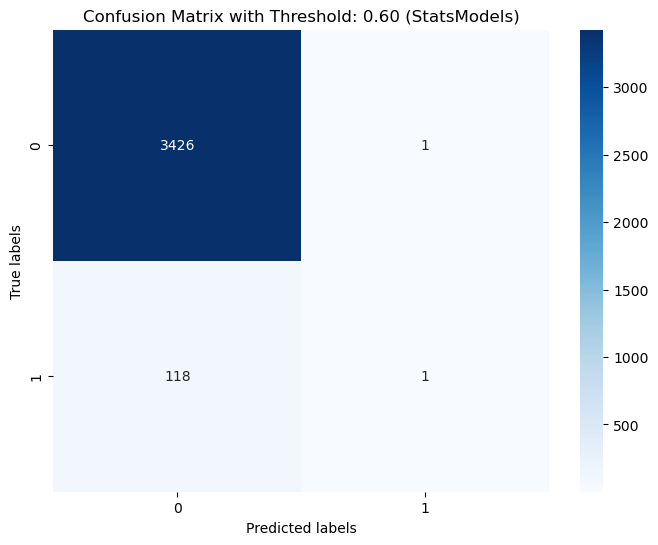

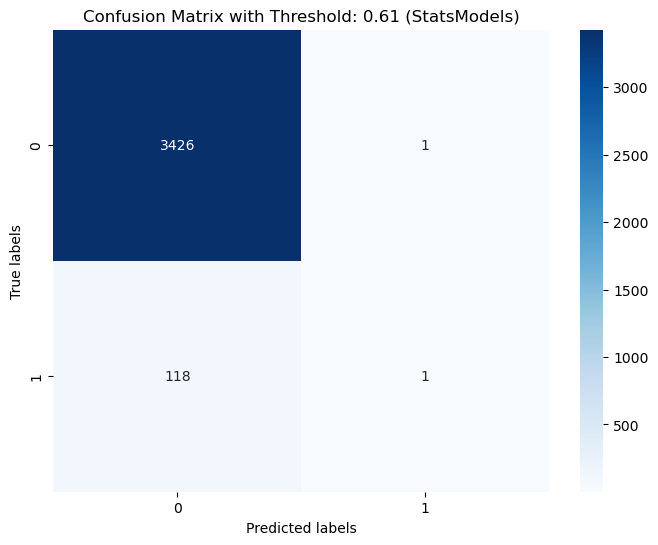

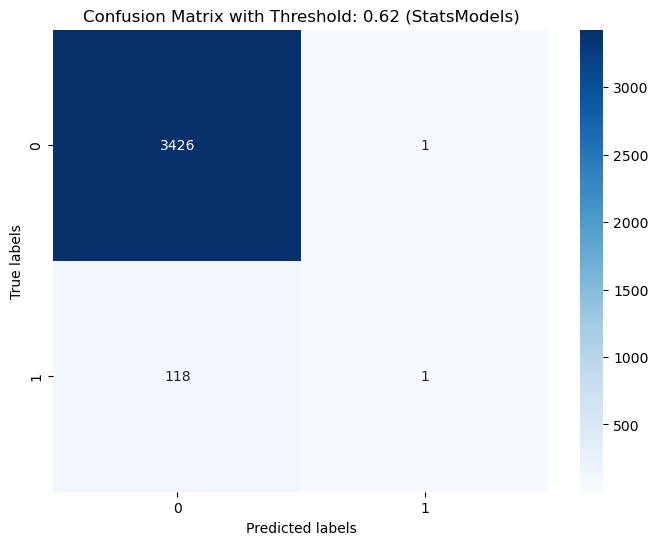

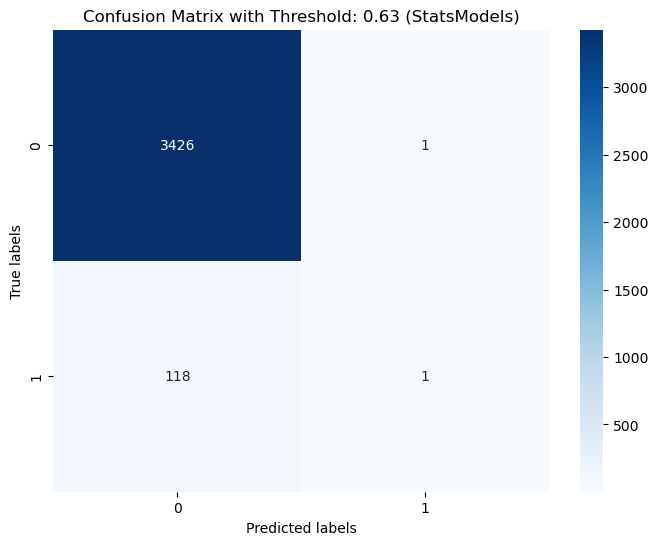

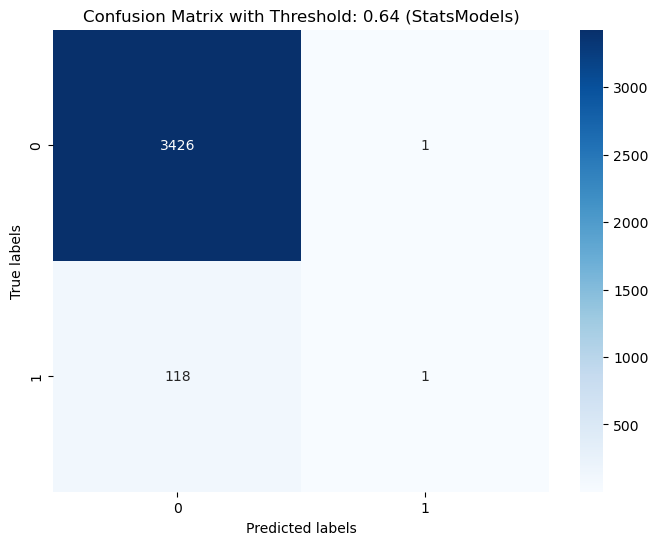

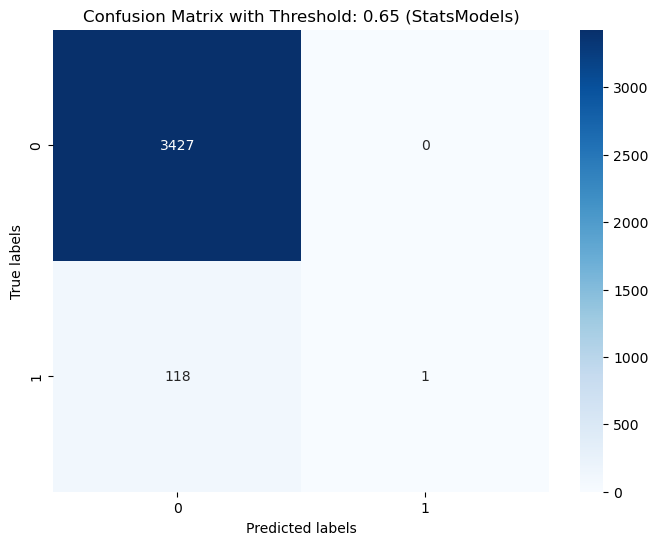

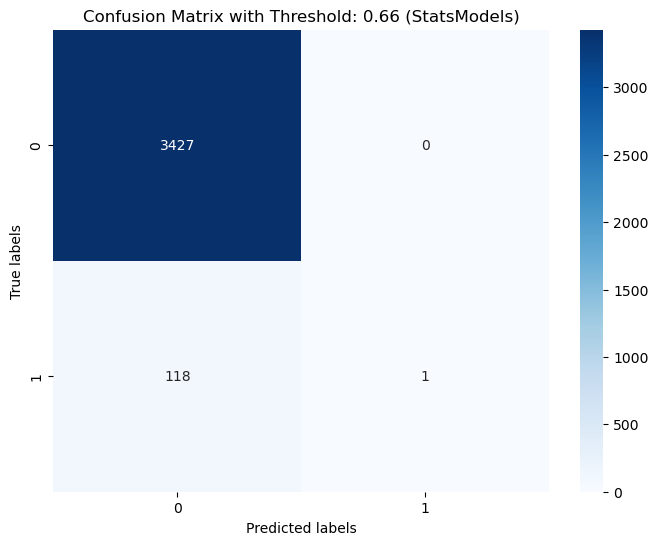

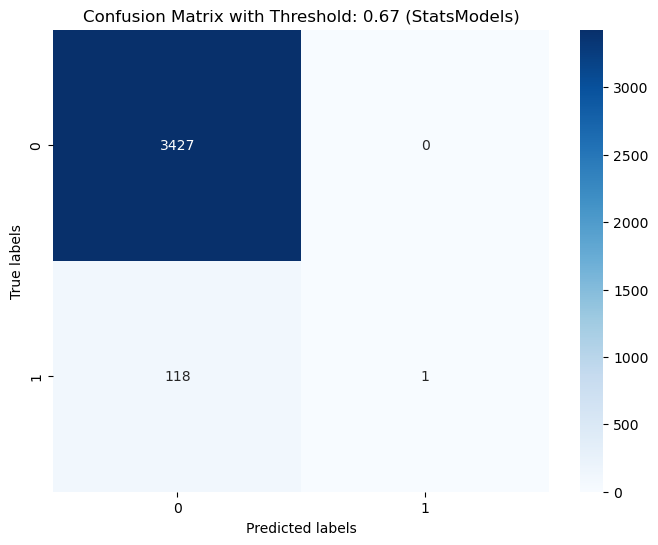

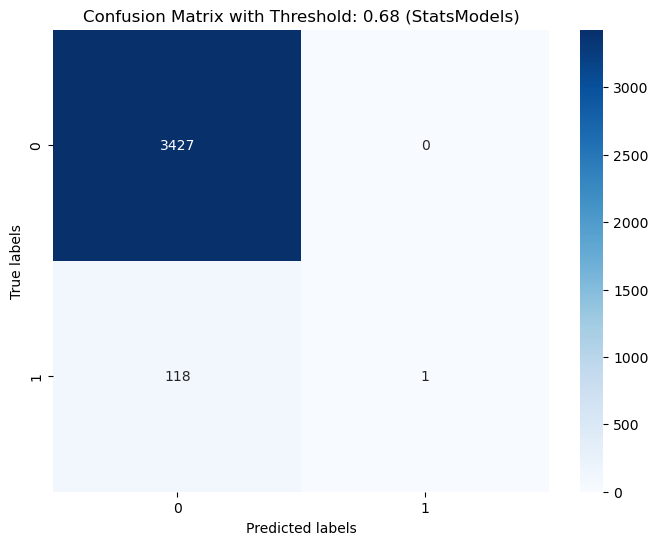

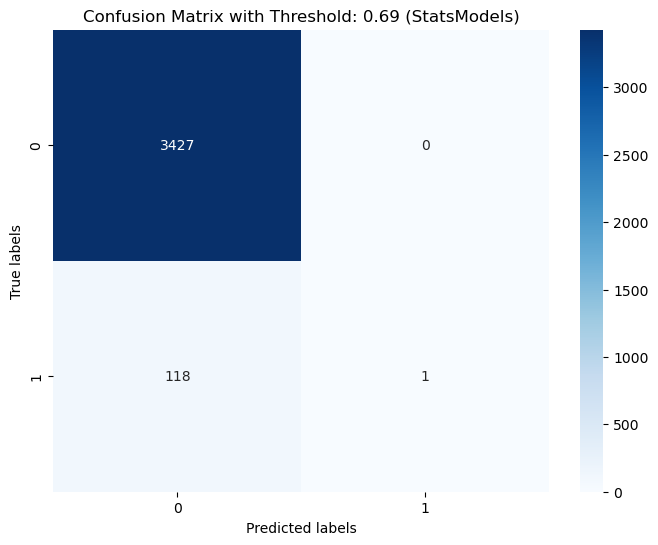

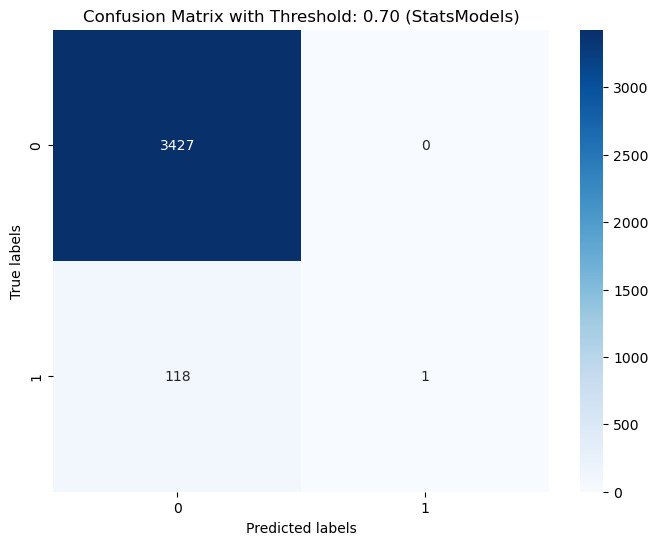

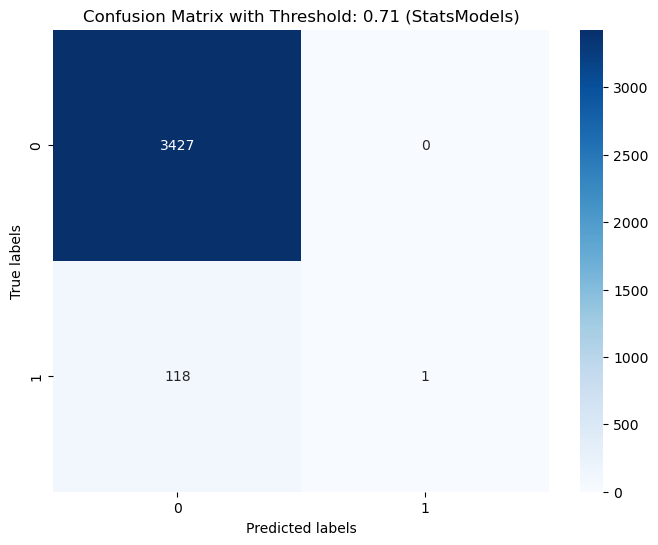

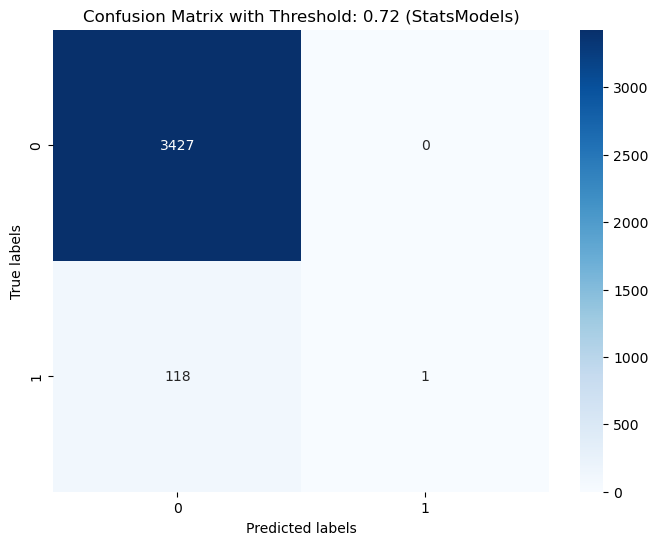

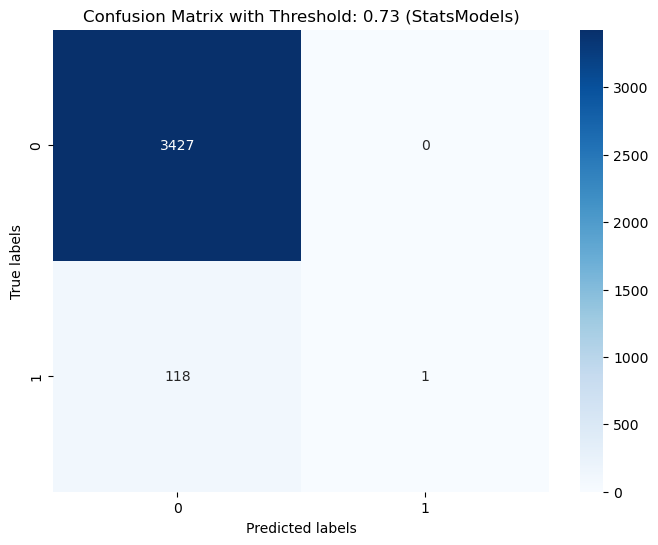

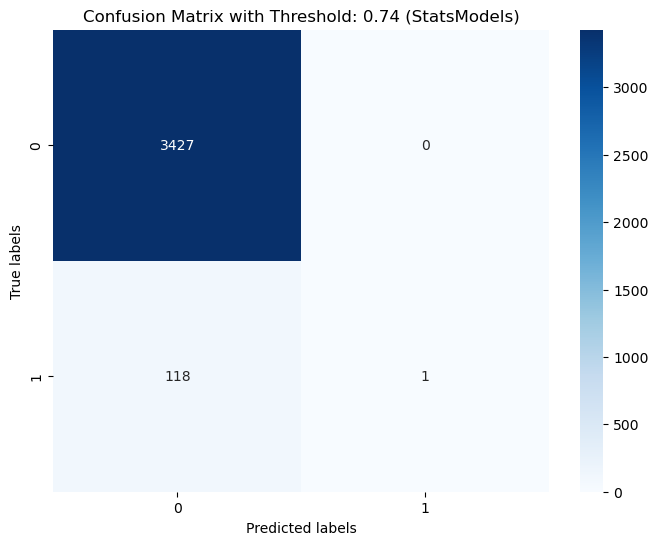

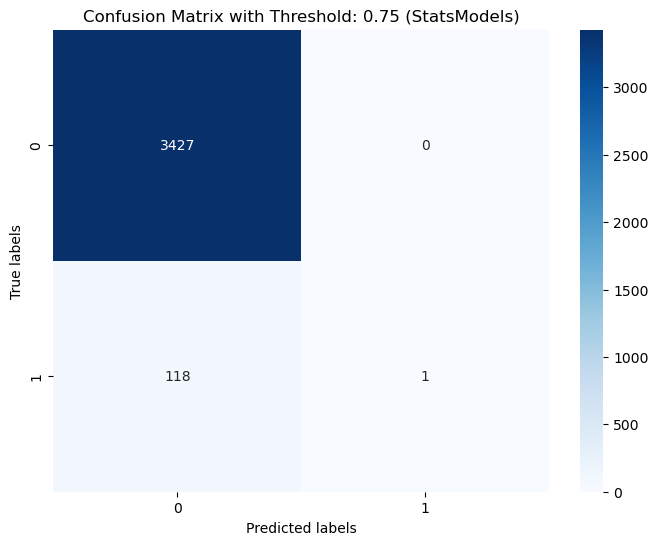

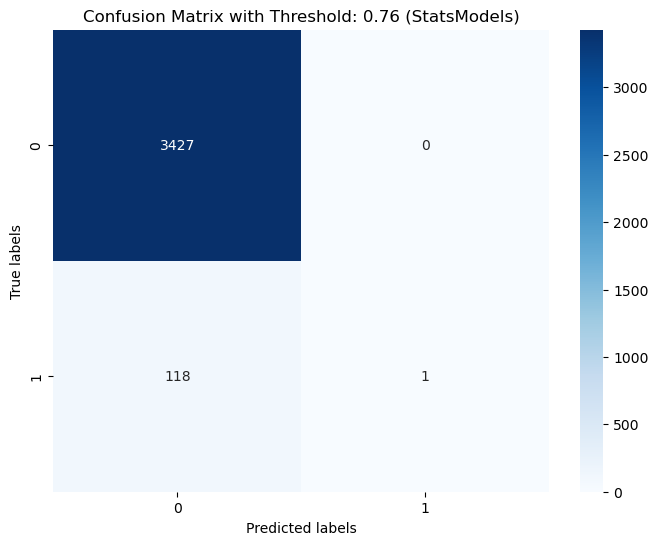

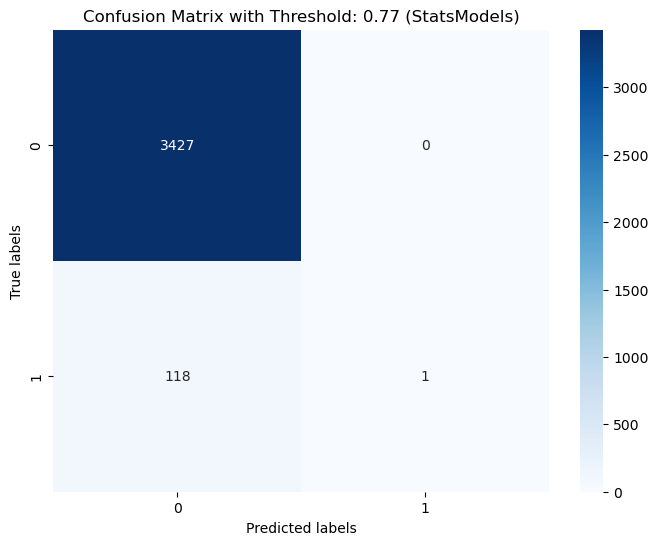

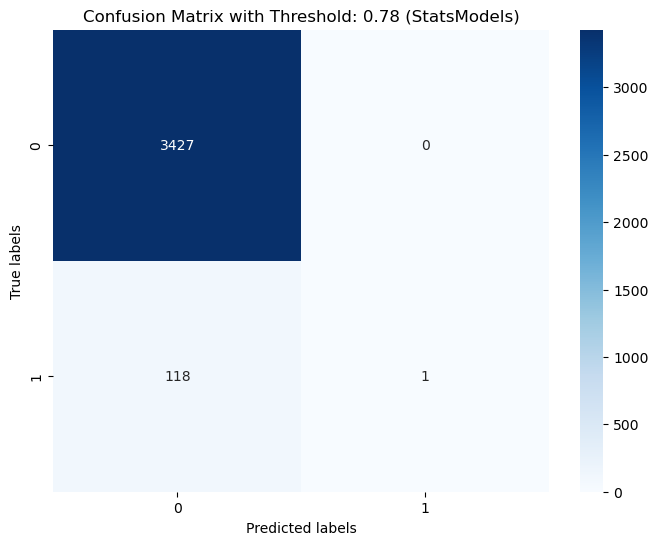

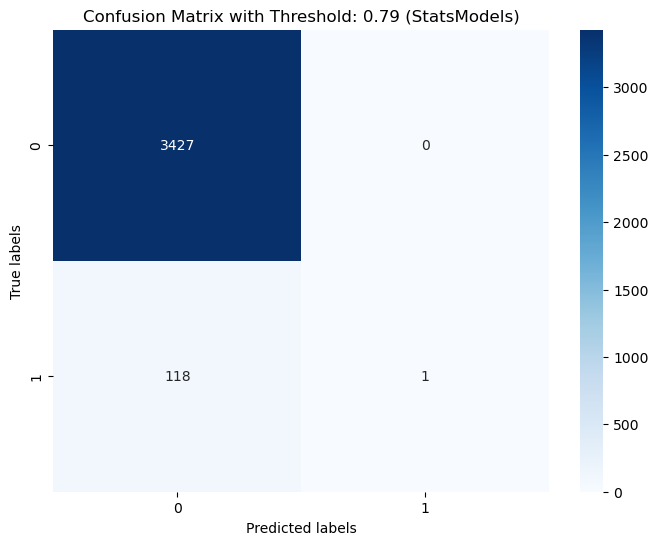

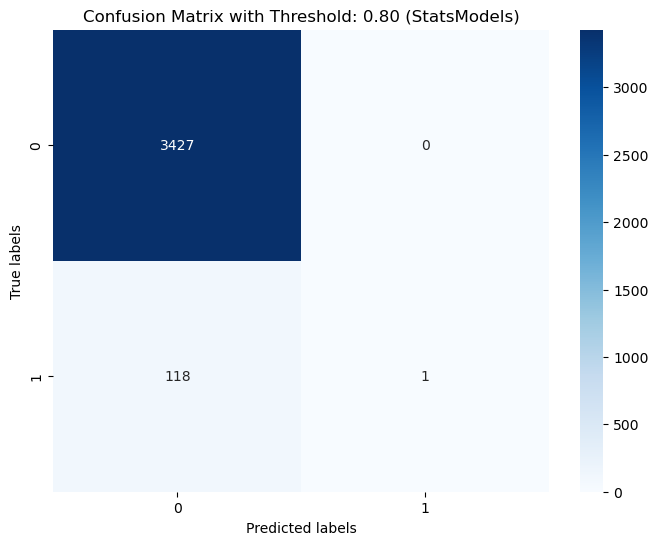

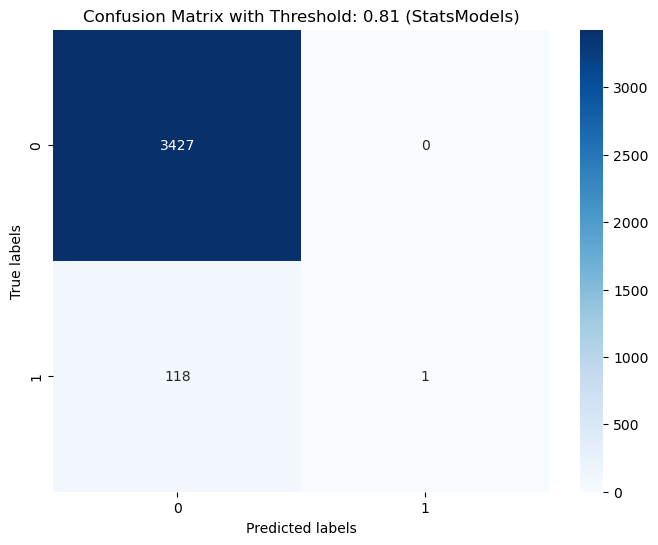

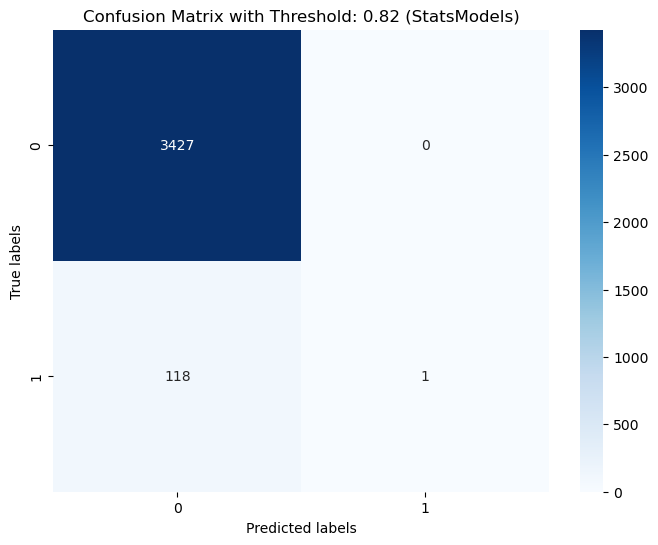

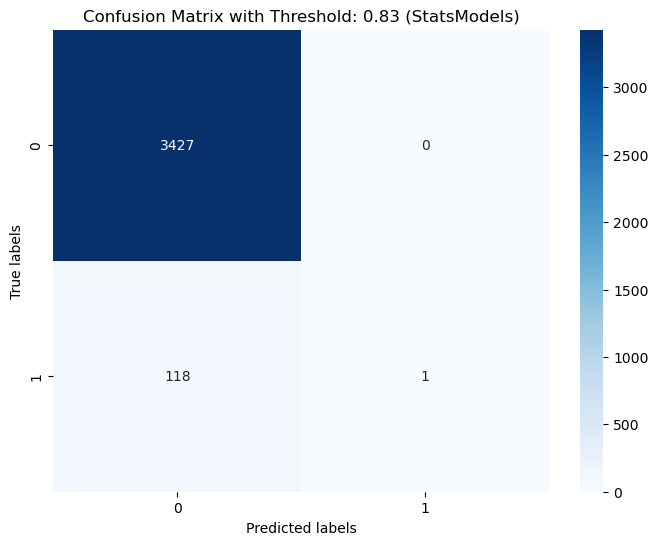

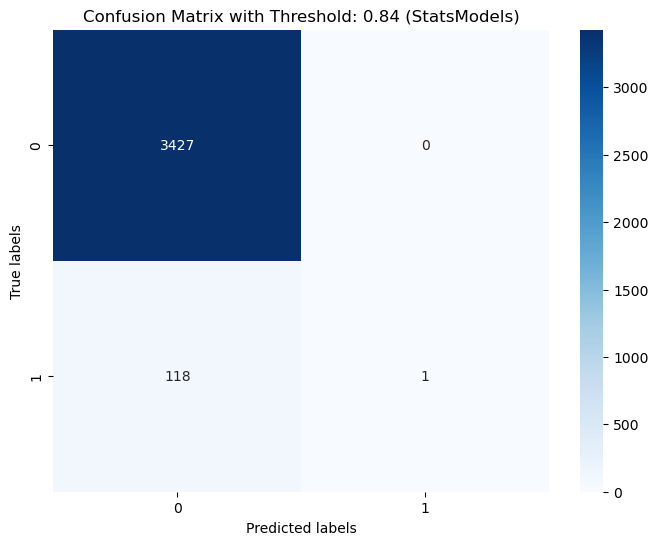

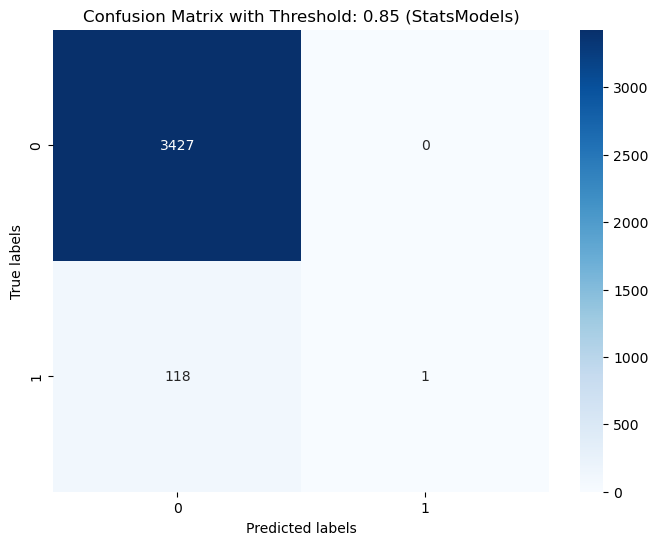

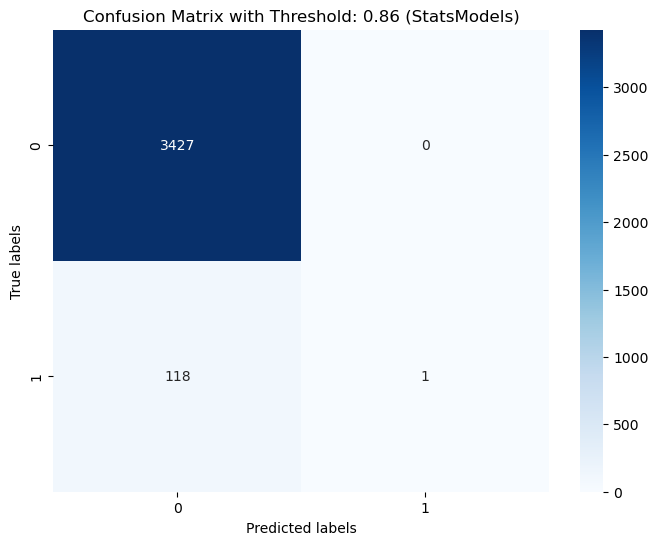

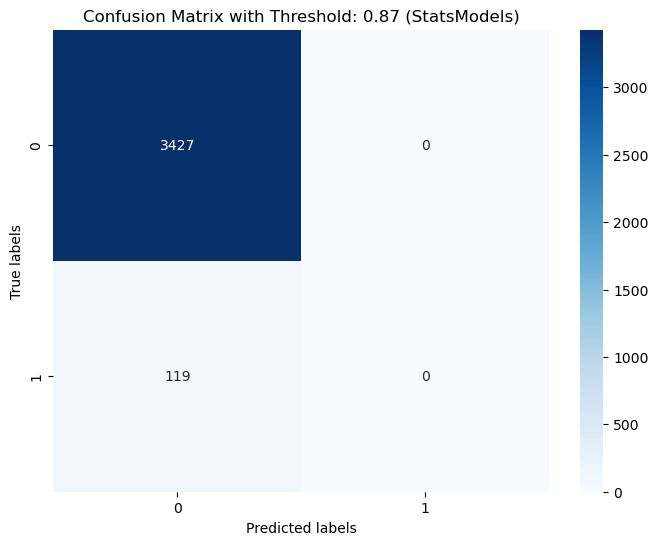

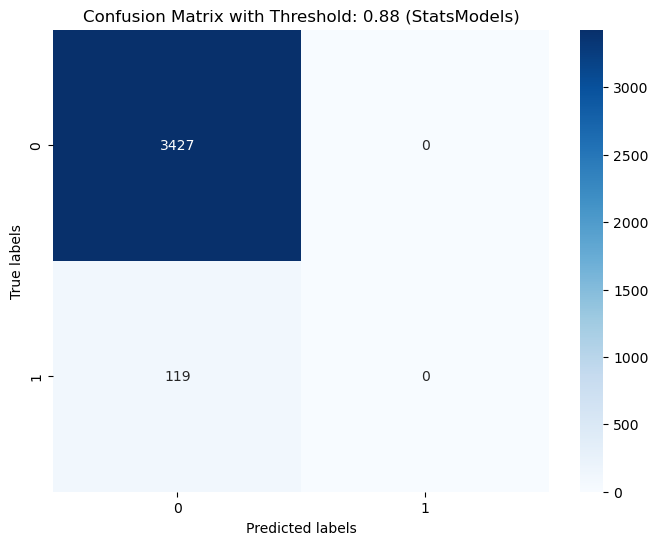

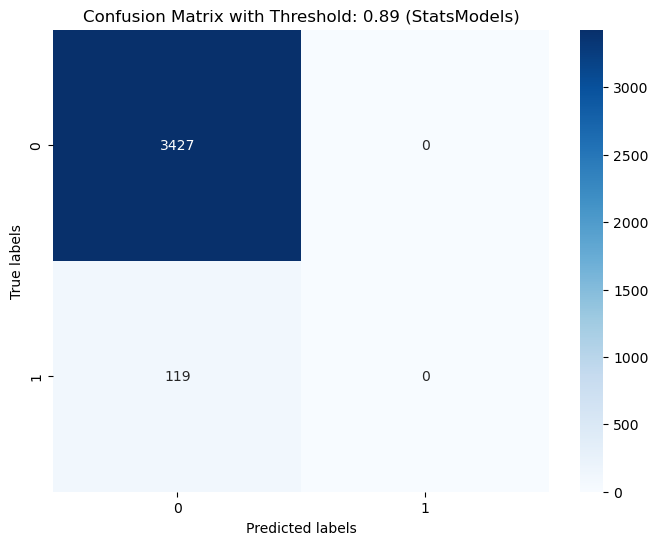

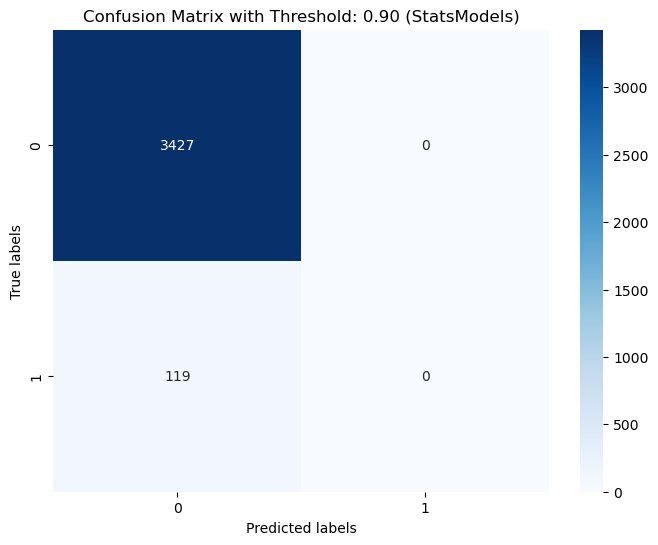

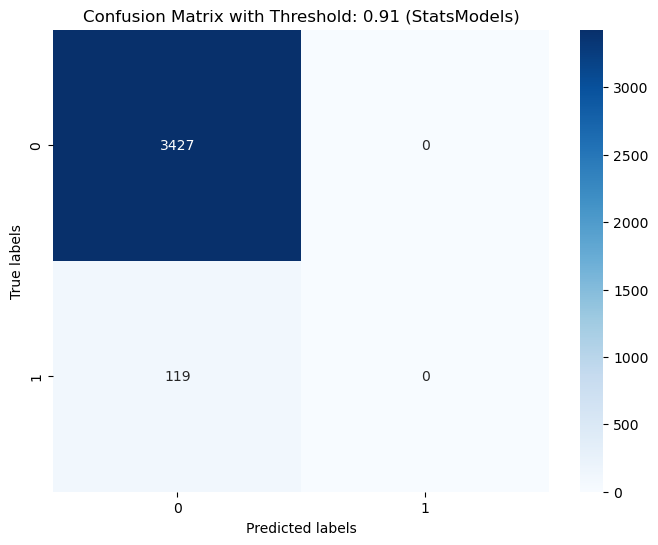

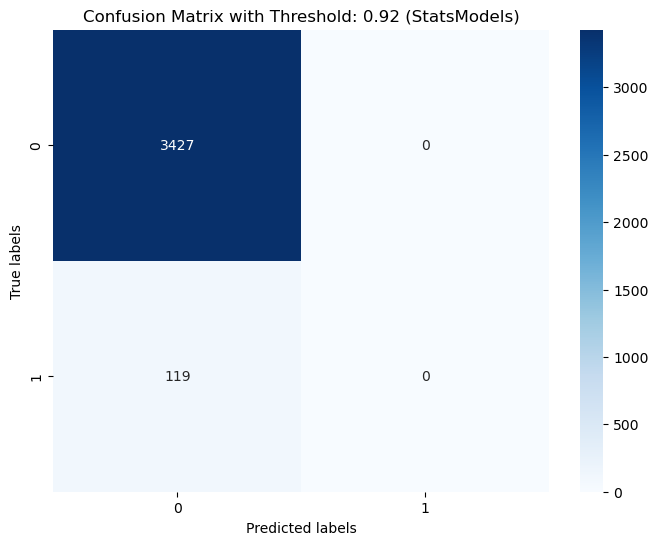

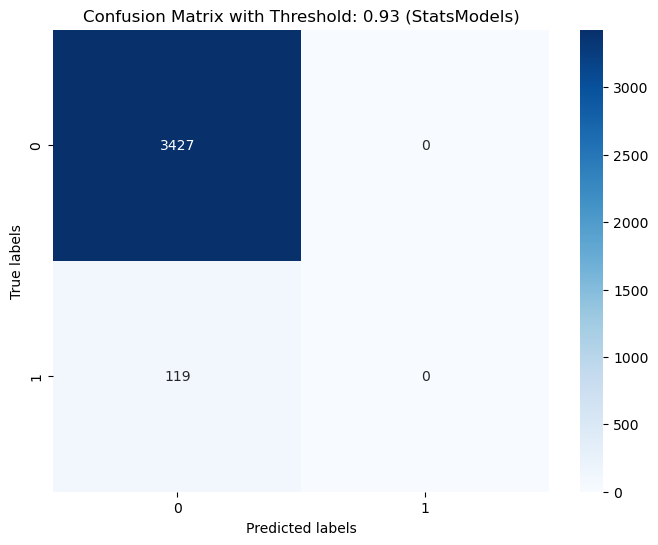

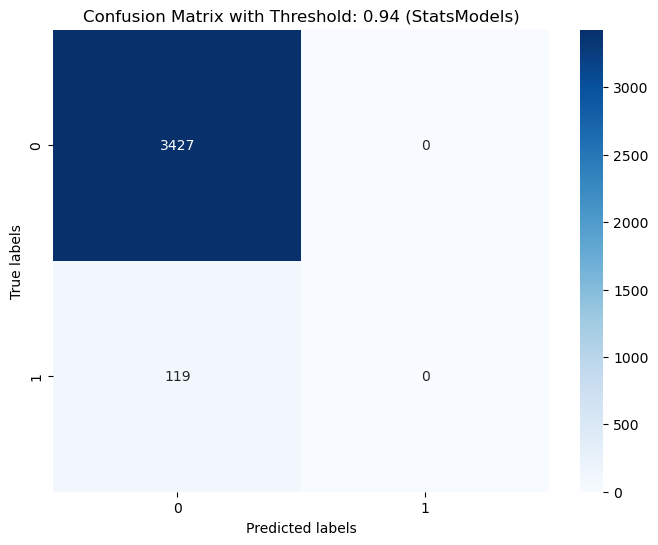

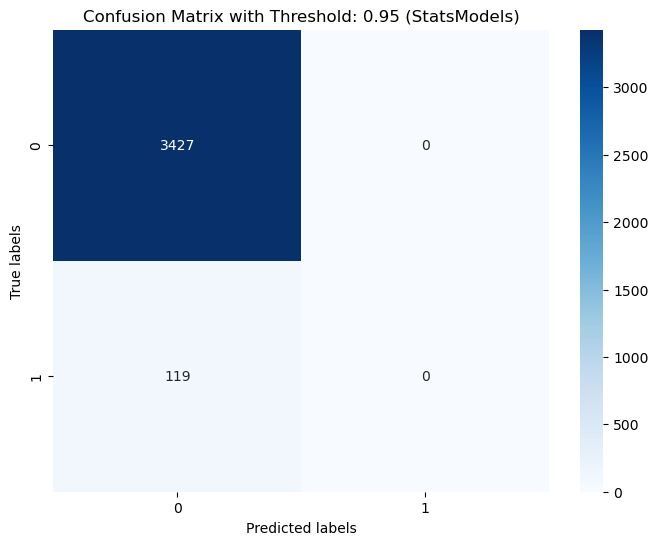

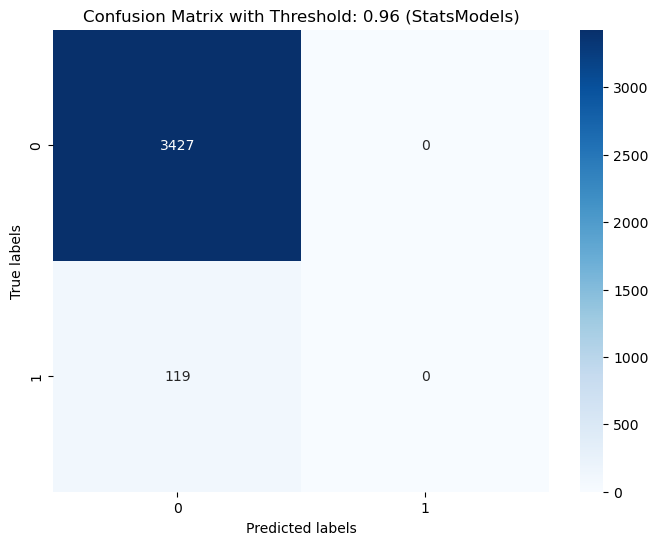

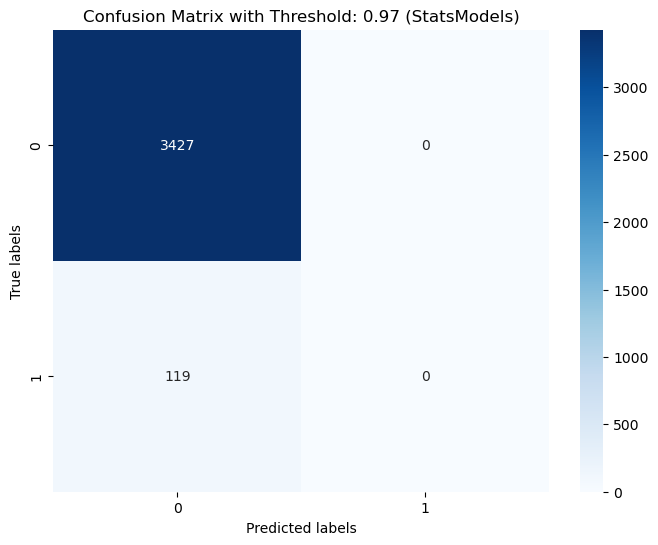

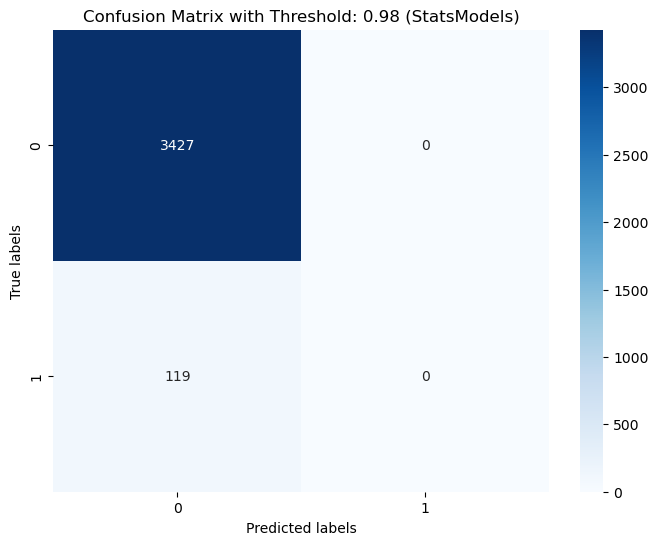

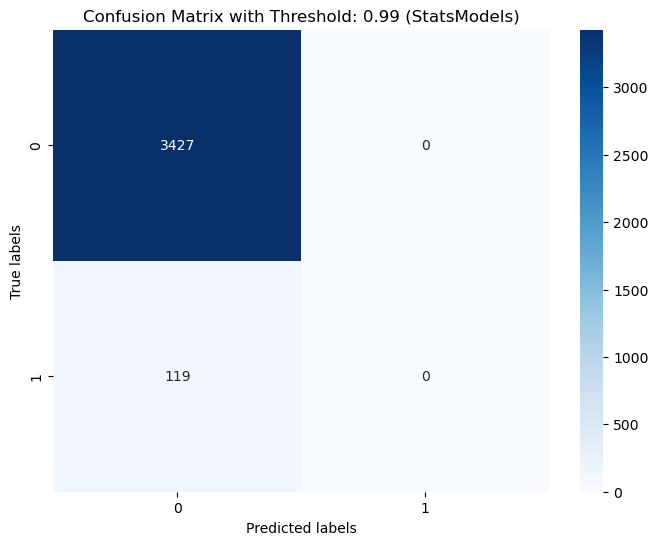

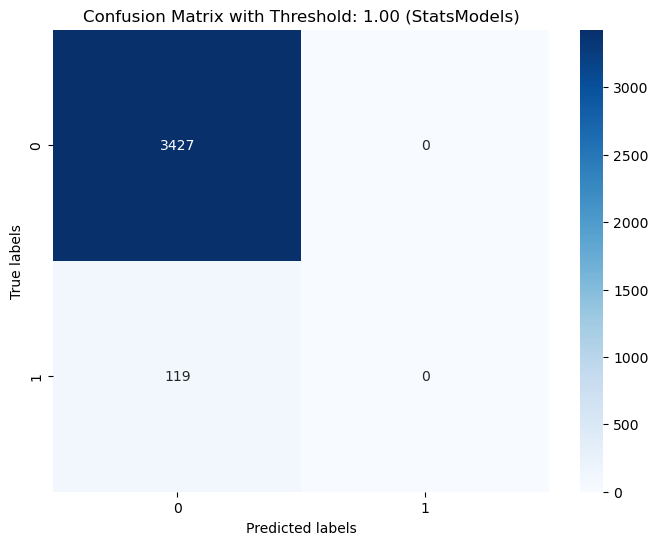

In [20]:
y_proba_sm = model_sm.predict(X_test_sm)

# Definiowanie różnych progów
thresholds = np.arange(0.01, 1.01, 0.01)

# Iteracja przez progi i generowanie macierzy pomyłek dla każdego progu
for threshold in thresholds:
    # Przypisanie nowych etykiet na podstawie progu
    y_pred_custom_threshold_sm = np.where(y_proba_sm >= threshold, 1, 0)
    
    # Generowanie macierzy pomyłek
    conf_matrix_custom_threshold_sm = confusion_matrix(y_test, y_pred_custom_threshold_sm)
    
    # Wizualizacja macierzy pomyłek
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_custom_threshold_sm, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix with Threshold: {threshold:.2f} (StatsModels)')
    plt.show()


Models beetwen threshold 0,02 and 0,03 seem to be the best optimzed. Let's chceck a models beetwen this numeric space


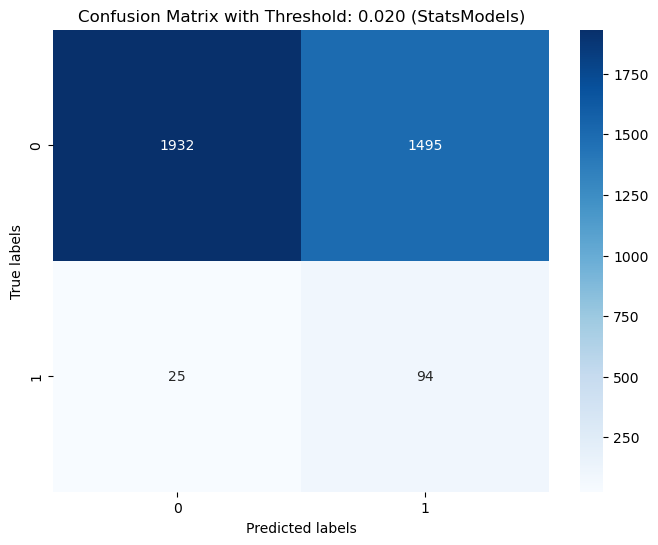

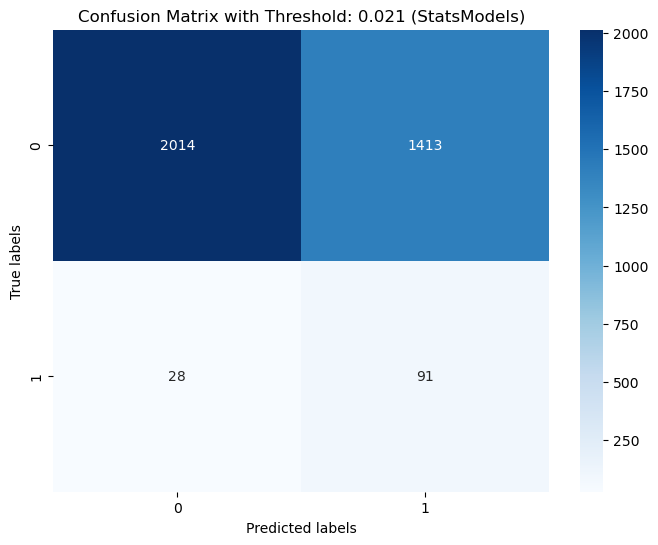

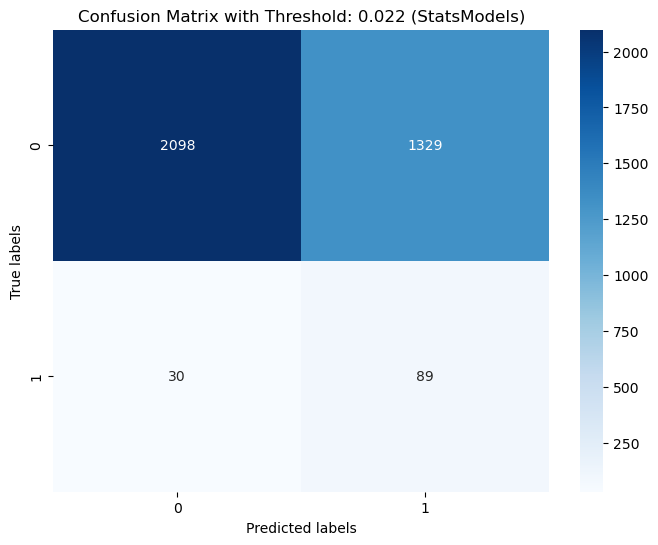

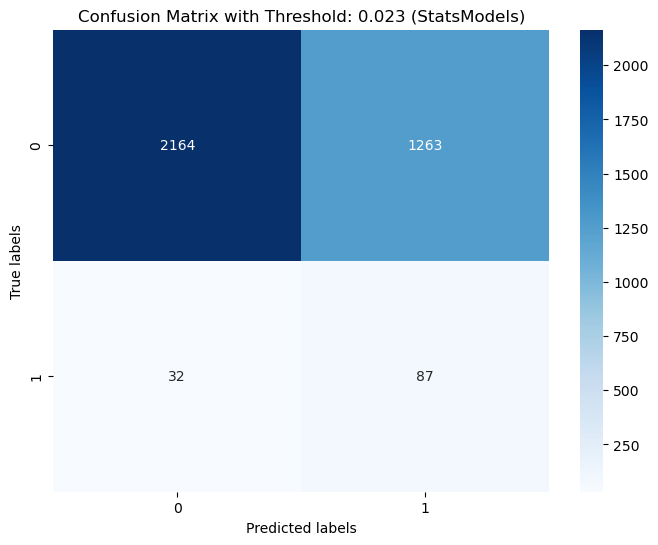

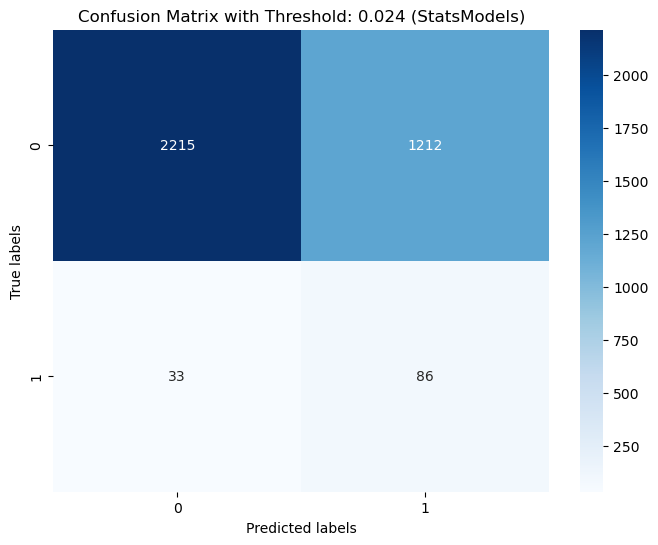

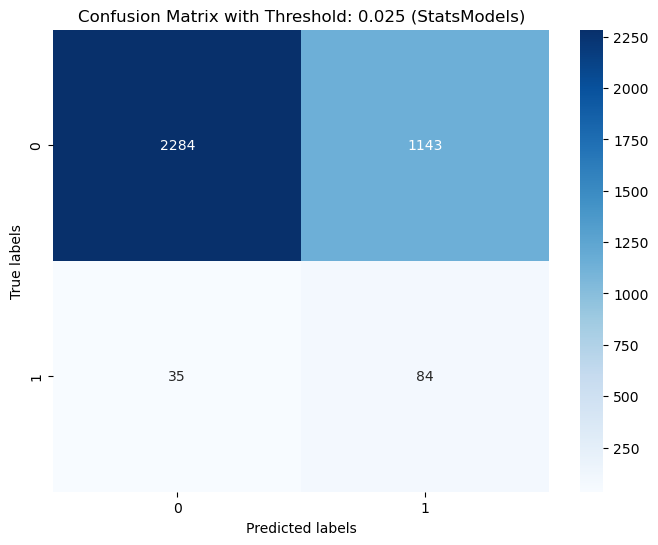

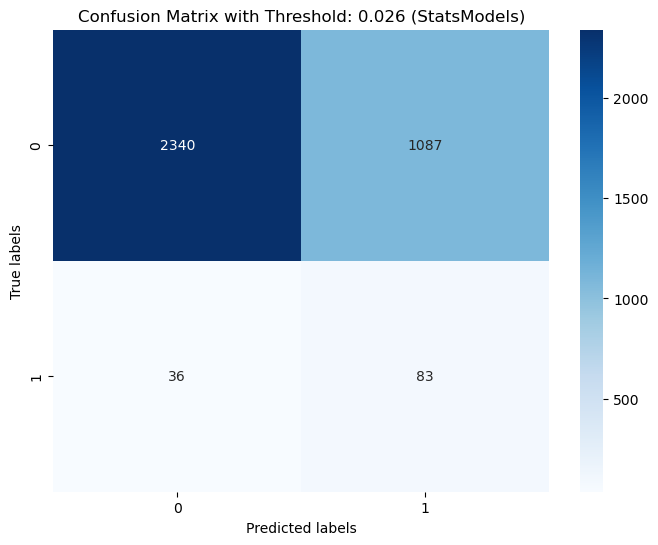

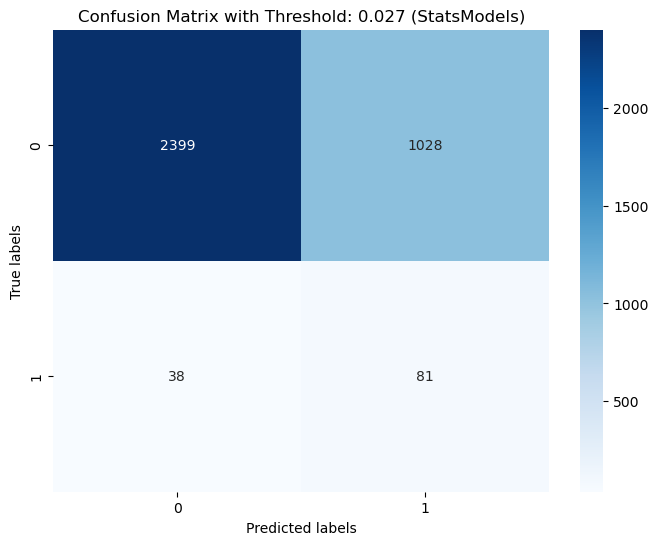

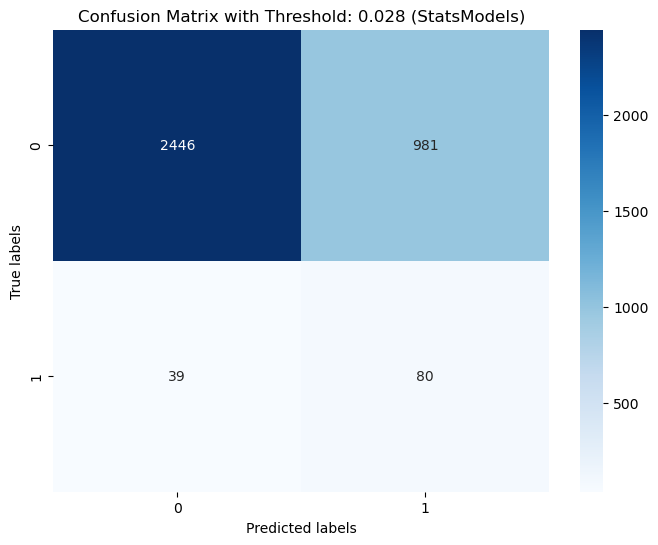

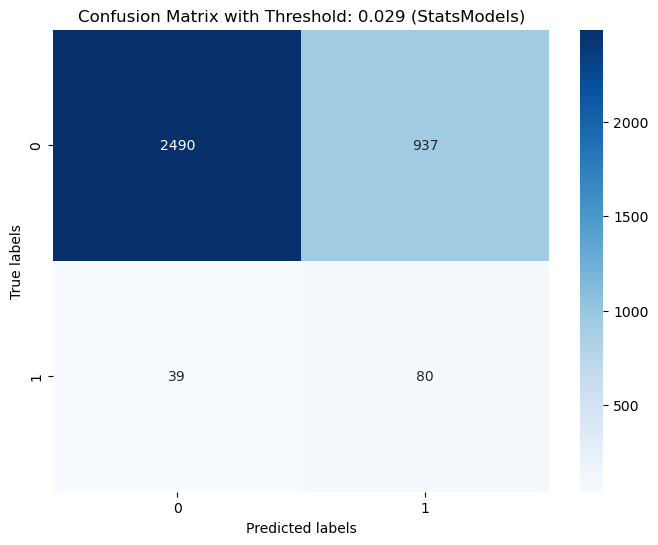

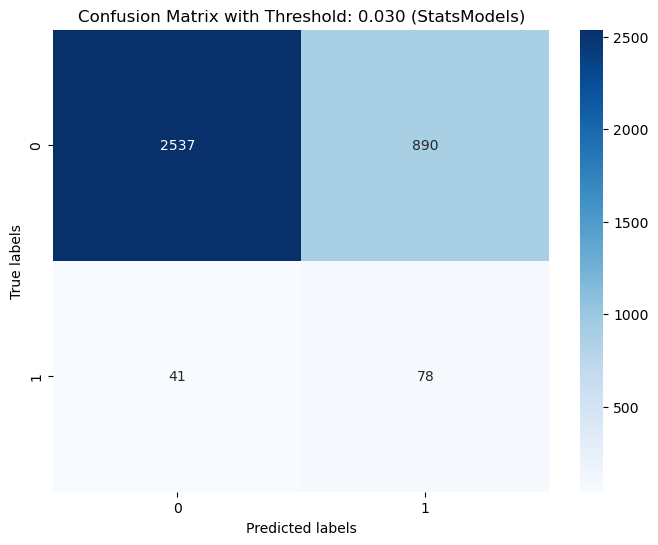

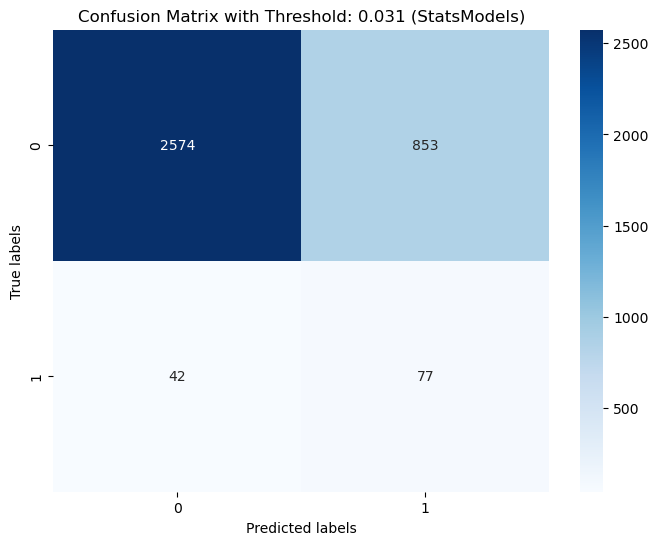

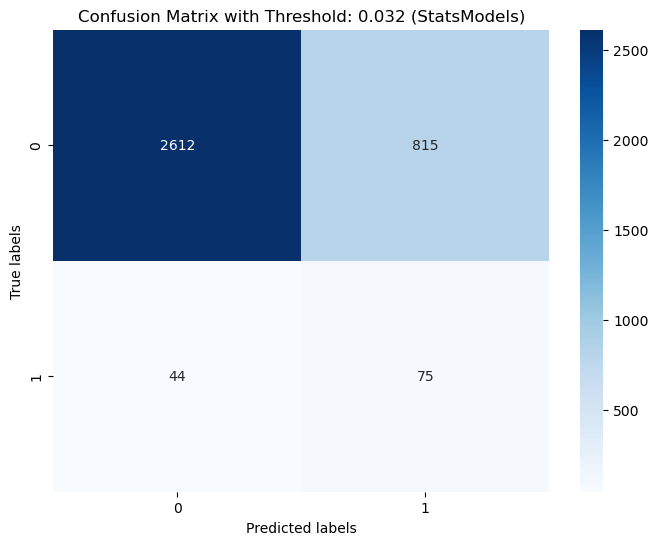

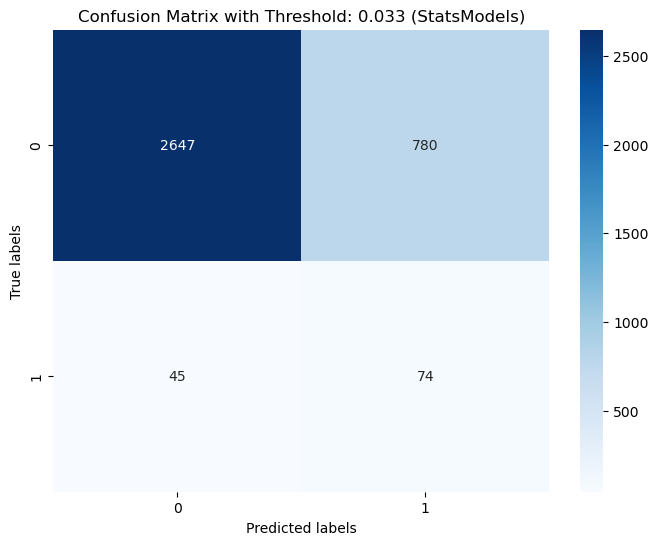

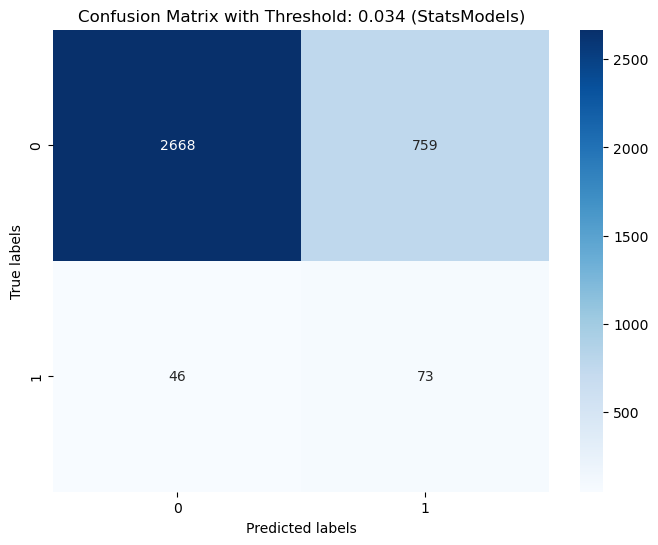

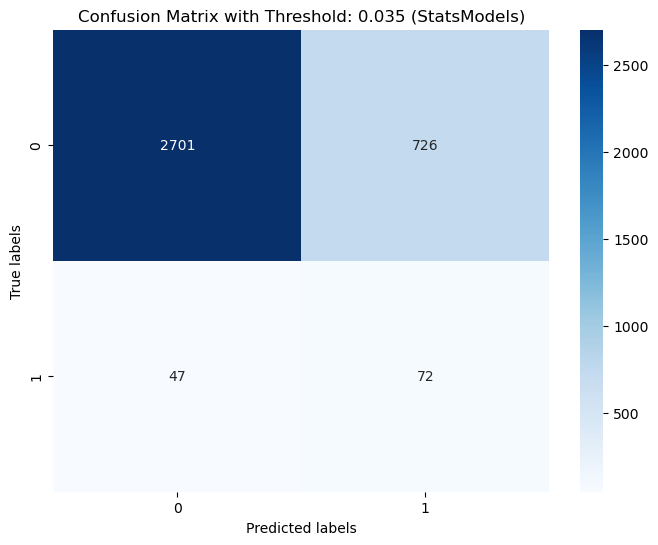

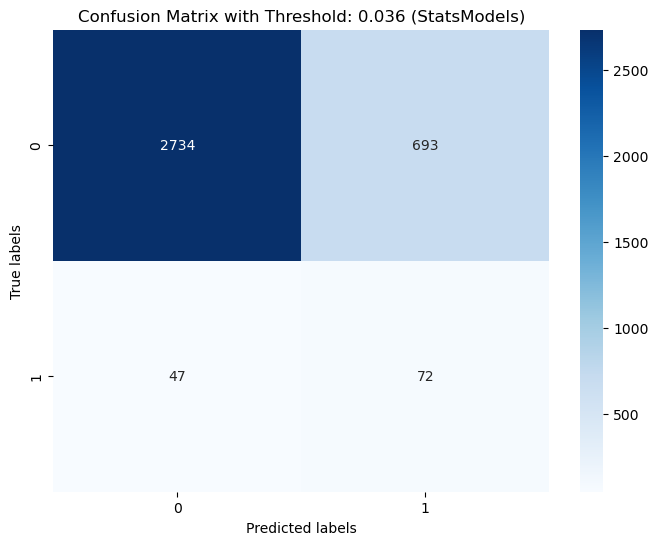

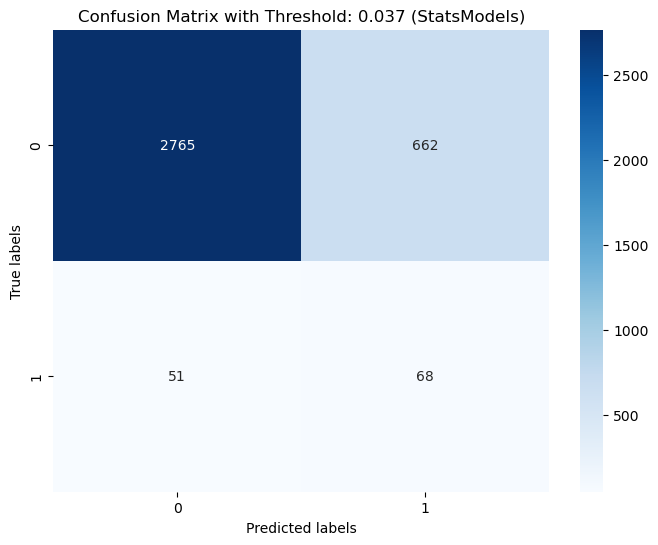

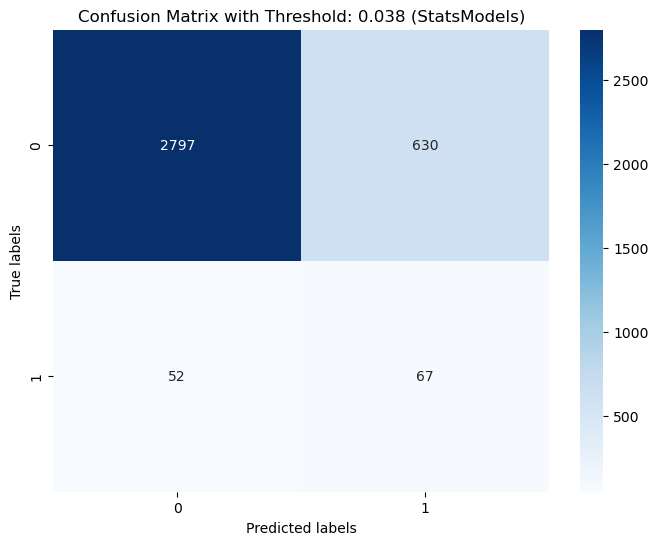

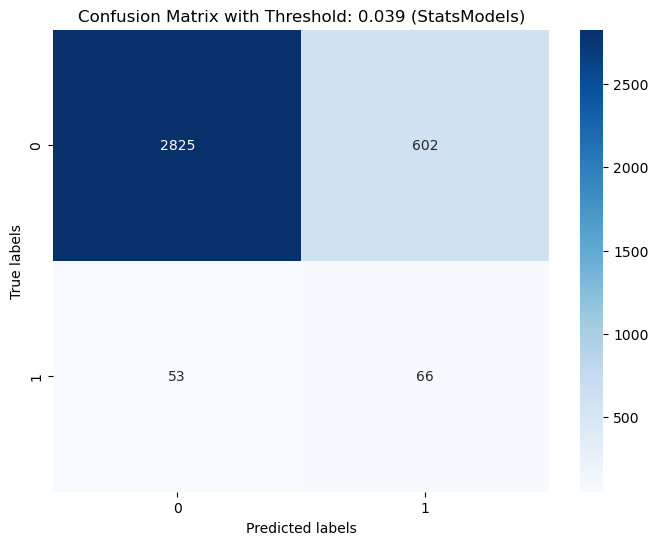

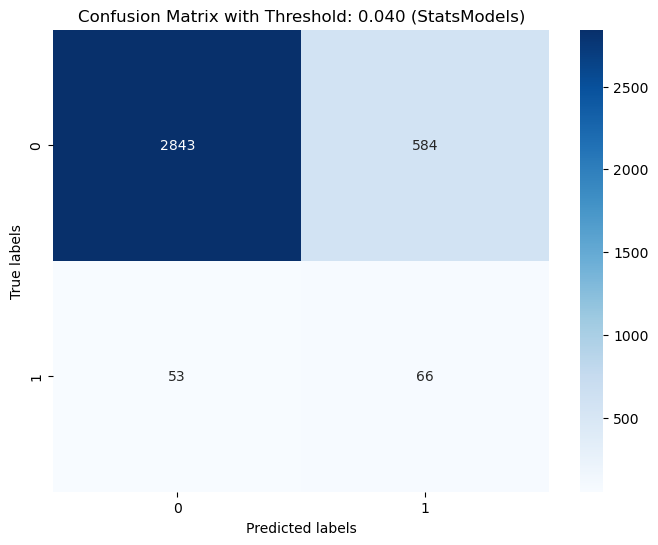

In [21]:
# Definiowanie nowego zakresu progów od 0.02 do 0.03 (włącznie) z krokiem 0.001
thresholds_fine = np.arange(0.02, 0.041, 0.001)

# Wydrukowanie wygenerowanych progów dla weryfikacji
thresholds_fine
for threshold in thresholds_fine:
    # Przypisanie nowych etykiet na podstawie progu
    y_pred_custom_threshold_sm = np.where(y_proba_sm >= threshold, 1, 0)
    
    # Generowanie macierzy pomyłek
    conf_matrix_custom_threshold_sm = confusion_matrix(y_test, y_pred_custom_threshold_sm)
    
    # Wizualizacja macierzy pomyłek
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_custom_threshold_sm, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix with Threshold: {threshold:.3f} (StatsModels)')
    plt.show()

Model with threshold equal ot 0,026 seems to be the most accurate based on our strategy predictions

Optimization terminated successfully.
         Current function value: 0.116173
         Iterations 9


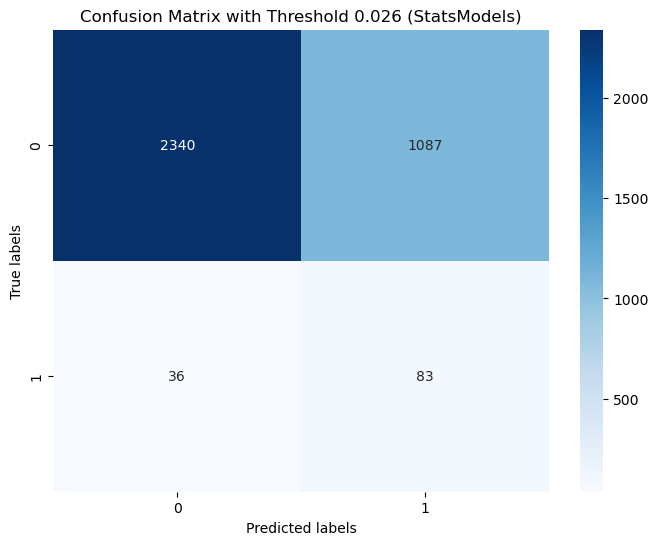

Accuracy: 0.6833
Precision: 0.0709
Recall: 0.6975
F1 Score: 0.1288


In [22]:
# Create a start model: simple logit with all variables, for which threshold is equal to 0,026
model_sm = sm.Logit(y_train_sm, X_train_sm).fit()

# Przewidywanie prawdopodobieństw dla danych testowych (bez zmian)
X_test_sm = sm.add_constant(X_test)
y_pred_prob_sm = model_sm.predict(X_test_sm)

# Zamiana prawdopodobieństw na etykiety klasy na podstawie progu 0.026
y_pred_sm = (y_pred_prob_sm >= 0.026).astype(int)

# Generowanie macierzy pomyłek
conf_matrix_sm = confusion_matrix(y_test, y_pred_sm)

# Wizualizacja macierzy pomyłek
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_sm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix with Threshold 0.026 (StatsModels)')
plt.show()
accuracy = accuracy_score(y_test, y_pred_sm)
precision = precision_score(y_test, y_pred_sm)
recall = recall_score(y_test, y_pred_sm)
f1 = f1_score(y_test, y_pred_sm)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


AUC: 0.7621
Gini Coefficient: 0.5242


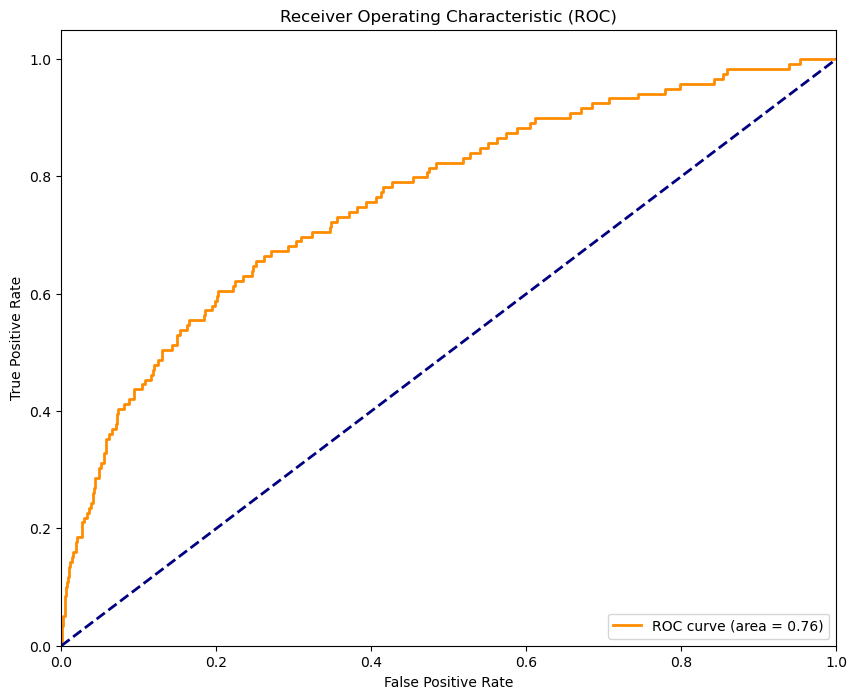

In [23]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Już obliczone AUC i Gini
auc = roc_auc_score(y_test, y_pred_prob_sm)
gini = 2 * auc - 1

print(f"AUC: {auc:.4f}")
print(f"Gini Coefficient: {gini:.4f}")

# Generowanie współczynników dla krzywej ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_sm)

# Rysowanie krzywej ROC
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc:.2f})')  # Używam już obliczonej wartości AUC
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()



# Modifying set of variables to improve predictions using RFE algorithm

In [25]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Inicjalizacja modelu regresji logistycznej
model = LogisticRegression()

# RFE
rfe = RFE(estimator=model, n_features_to_select=1)
rfe = rfe.fit(X_train_sm, y_train_sm)

# Ranking cech
print('Ranking cech:', rfe.ranking_)


c:\Users\jansl\.conda\envs\Spyder\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Ranking cech: [19  1  6  9  3  7 11 15  2  5 18 17  8 13 10 14  4 12 16]


On the list above we have a rank of the elements in accordance to column index. Below there is a plot which ilustrate this

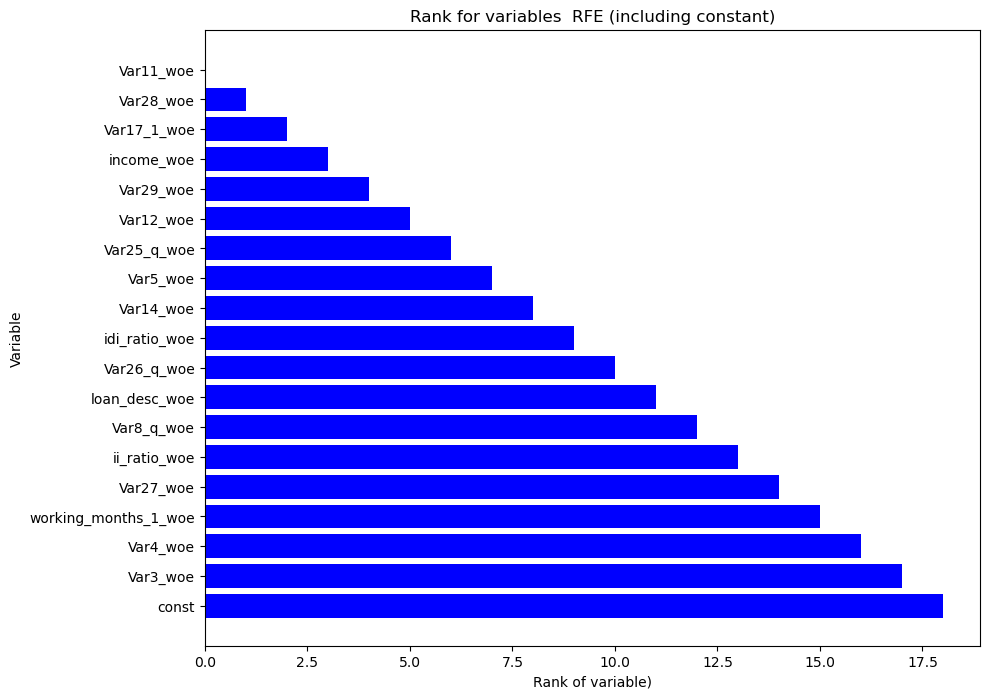

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Przygotowanie rankingu cech zorientowanego na 0-based indexing
ranking_0_based = rfe.ranking_ - 1

# Sortowanie indeksów według rankingu
sorted_idx = np.argsort(ranking_0_based)

# Utworzenie posortowanej listy rankingów
sorted_ranking = ranking_0_based[sorted_idx]

# Zakładając, że mamy listę wszystkich nazw cech, wliczając stałą
feature_names = X_train_sm.columns

# Utworzenie listy posortowanych nazw cech na podstawie indeksów
sorted_feature_names = [feature_names[i] for i in sorted_idx]

# Tworzenie wykresu rangi ważności cech
plt.figure(figsize=(10, 8))
plt.title("Rank for variables  RFE (including constant)")
plt.barh(range(len(sorted_feature_names)), sorted_ranking, color='blue', align='center')
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.xlabel("Rank of variable)")
plt.ylabel("Variable")
plt.gca().invert_yaxis()  # Odwrócenie kolejności, aby najważniejsze cechy były na górze
plt.show()


Below there is a algorithm which allows us to elminate variables based on our RFE rank 

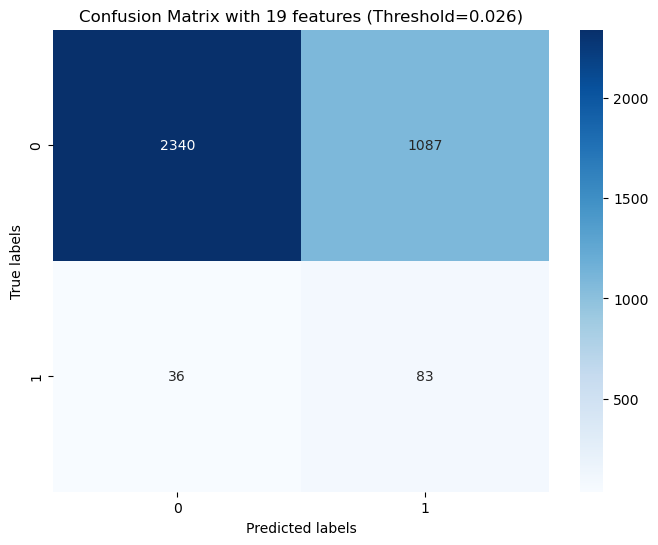

Features removed: []

Features included in the model: ['const', 'Var3_woe', 'Var4_woe', 'working_months_1_woe', 'Var27_woe', 'ii_ratio_woe', 'Var8_q_woe', 'loan_desc_woe', 'Var26_q_woe', 'idi_ratio_woe', 'Var14_woe', 'Var5_woe', 'Var25_q_woe', 'Var12_woe', 'Var29_woe', 'income_woe', 'Var17_1_woe', 'Var28_woe', 'Var11_woe']



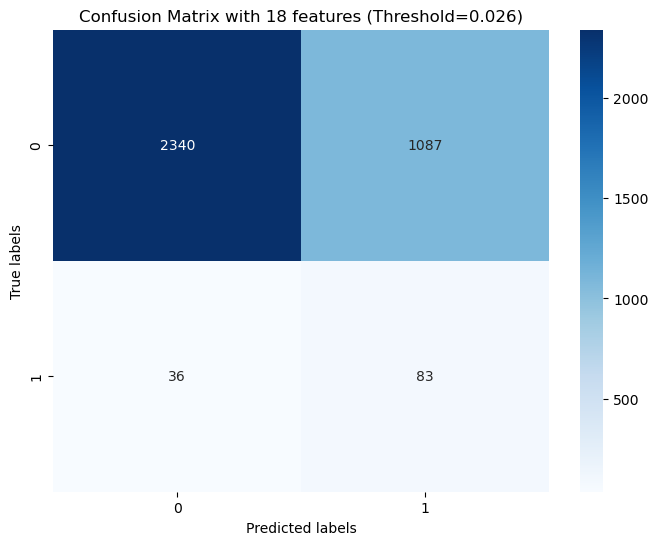

Features removed: ['const']

Features included in the model: ['Var3_woe', 'Var4_woe', 'working_months_1_woe', 'Var27_woe', 'ii_ratio_woe', 'Var8_q_woe', 'loan_desc_woe', 'Var26_q_woe', 'idi_ratio_woe', 'Var14_woe', 'Var5_woe', 'Var25_q_woe', 'Var12_woe', 'Var29_woe', 'income_woe', 'Var17_1_woe', 'Var28_woe', 'Var11_woe']



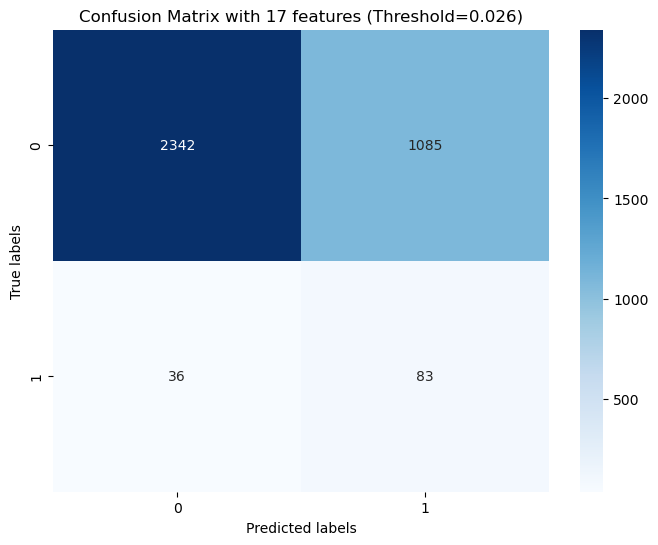

Features removed: ['const', 'Var3_woe']

Features included in the model: ['Var4_woe', 'working_months_1_woe', 'Var27_woe', 'ii_ratio_woe', 'Var8_q_woe', 'loan_desc_woe', 'Var26_q_woe', 'idi_ratio_woe', 'Var14_woe', 'Var5_woe', 'Var25_q_woe', 'Var12_woe', 'Var29_woe', 'income_woe', 'Var17_1_woe', 'Var28_woe', 'Var11_woe']



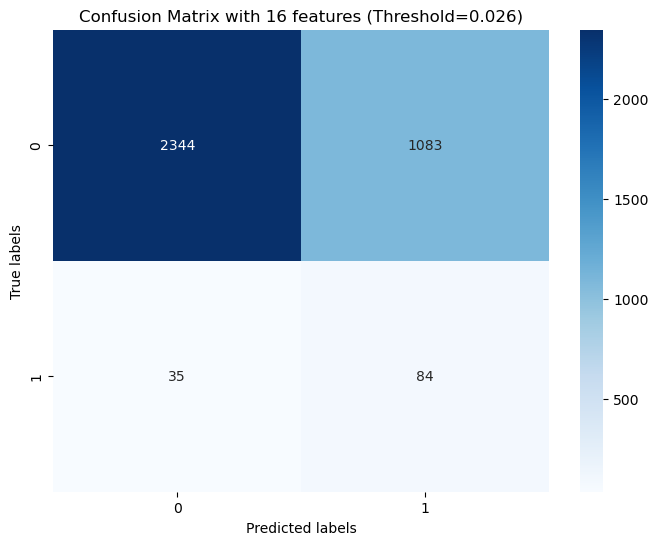

Features removed: ['const', 'Var3_woe', 'Var4_woe']

Features included in the model: ['working_months_1_woe', 'Var27_woe', 'ii_ratio_woe', 'Var8_q_woe', 'loan_desc_woe', 'Var26_q_woe', 'idi_ratio_woe', 'Var14_woe', 'Var5_woe', 'Var25_q_woe', 'Var12_woe', 'Var29_woe', 'income_woe', 'Var17_1_woe', 'Var28_woe', 'Var11_woe']



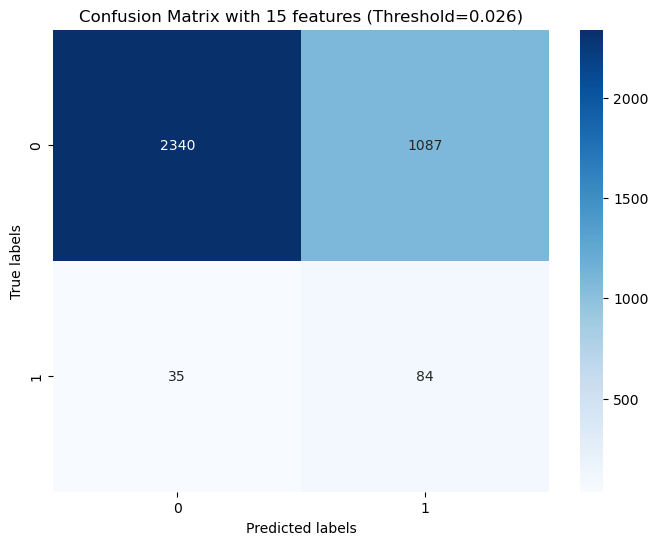

Features removed: ['const', 'Var3_woe', 'Var4_woe', 'working_months_1_woe']

Features included in the model: ['Var27_woe', 'ii_ratio_woe', 'Var8_q_woe', 'loan_desc_woe', 'Var26_q_woe', 'idi_ratio_woe', 'Var14_woe', 'Var5_woe', 'Var25_q_woe', 'Var12_woe', 'Var29_woe', 'income_woe', 'Var17_1_woe', 'Var28_woe', 'Var11_woe']



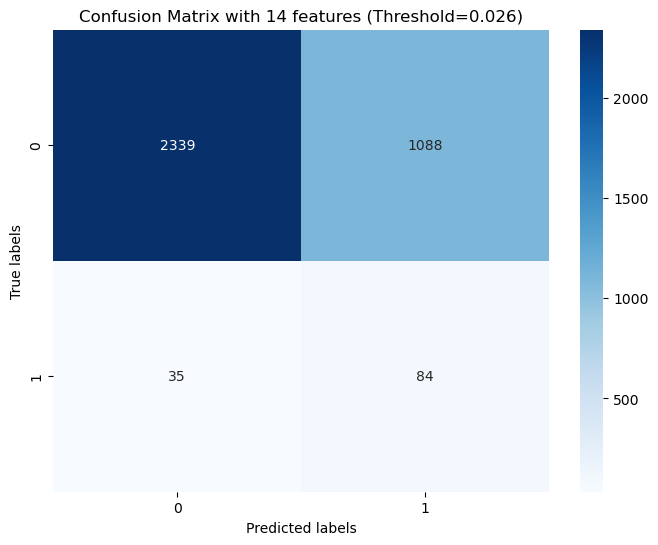

Features removed: ['const', 'Var3_woe', 'Var4_woe', 'working_months_1_woe', 'Var27_woe']

Features included in the model: ['ii_ratio_woe', 'Var8_q_woe', 'loan_desc_woe', 'Var26_q_woe', 'idi_ratio_woe', 'Var14_woe', 'Var5_woe', 'Var25_q_woe', 'Var12_woe', 'Var29_woe', 'income_woe', 'Var17_1_woe', 'Var28_woe', 'Var11_woe']



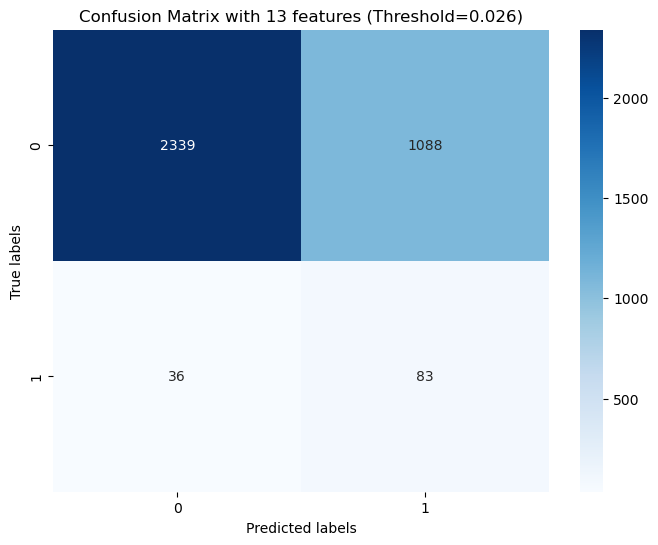

Features removed: ['const', 'Var3_woe', 'Var4_woe', 'working_months_1_woe', 'Var27_woe', 'ii_ratio_woe']

Features included in the model: ['Var8_q_woe', 'loan_desc_woe', 'Var26_q_woe', 'idi_ratio_woe', 'Var14_woe', 'Var5_woe', 'Var25_q_woe', 'Var12_woe', 'Var29_woe', 'income_woe', 'Var17_1_woe', 'Var28_woe', 'Var11_woe']



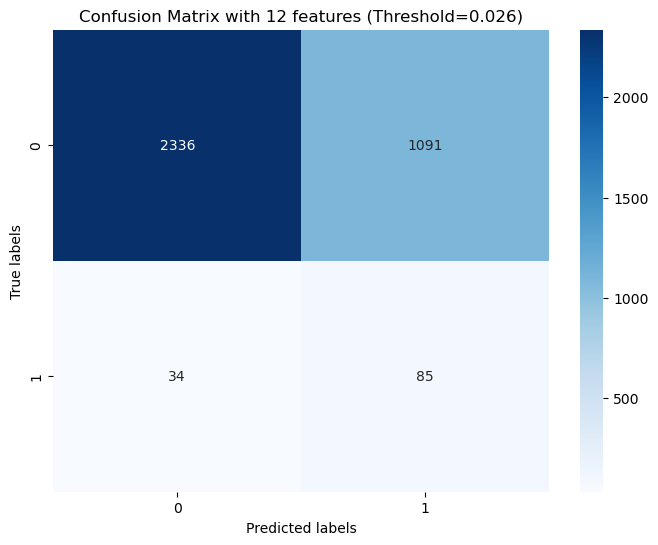

Features removed: ['const', 'Var3_woe', 'Var4_woe', 'working_months_1_woe', 'Var27_woe', 'ii_ratio_woe', 'Var8_q_woe']

Features included in the model: ['loan_desc_woe', 'Var26_q_woe', 'idi_ratio_woe', 'Var14_woe', 'Var5_woe', 'Var25_q_woe', 'Var12_woe', 'Var29_woe', 'income_woe', 'Var17_1_woe', 'Var28_woe', 'Var11_woe']



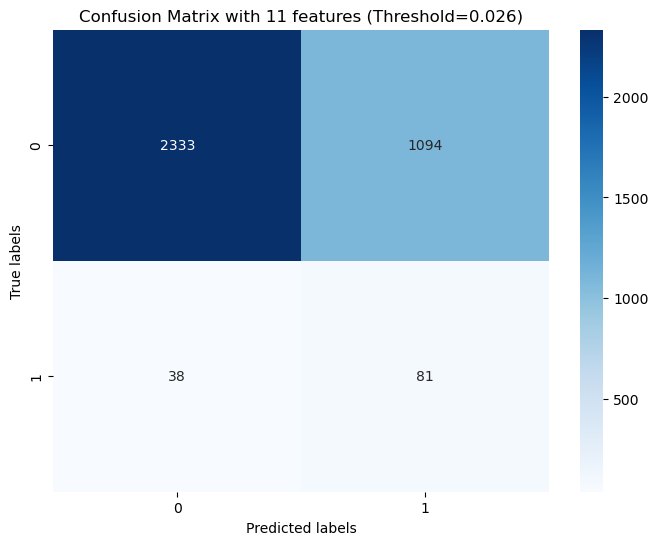

Features removed: ['const', 'Var3_woe', 'Var4_woe', 'working_months_1_woe', 'Var27_woe', 'ii_ratio_woe', 'Var8_q_woe', 'loan_desc_woe']

Features included in the model: ['Var26_q_woe', 'idi_ratio_woe', 'Var14_woe', 'Var5_woe', 'Var25_q_woe', 'Var12_woe', 'Var29_woe', 'income_woe', 'Var17_1_woe', 'Var28_woe', 'Var11_woe']



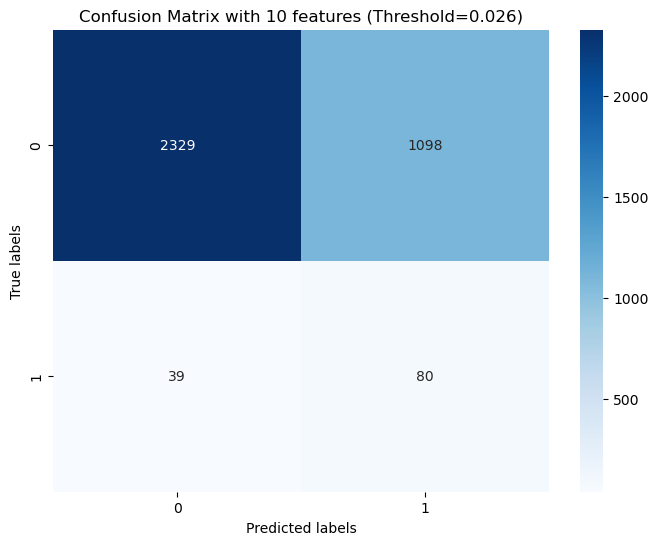

Features removed: ['const', 'Var3_woe', 'Var4_woe', 'working_months_1_woe', 'Var27_woe', 'ii_ratio_woe', 'Var8_q_woe', 'loan_desc_woe', 'Var26_q_woe']

Features included in the model: ['idi_ratio_woe', 'Var14_woe', 'Var5_woe', 'Var25_q_woe', 'Var12_woe', 'Var29_woe', 'income_woe', 'Var17_1_woe', 'Var28_woe', 'Var11_woe']



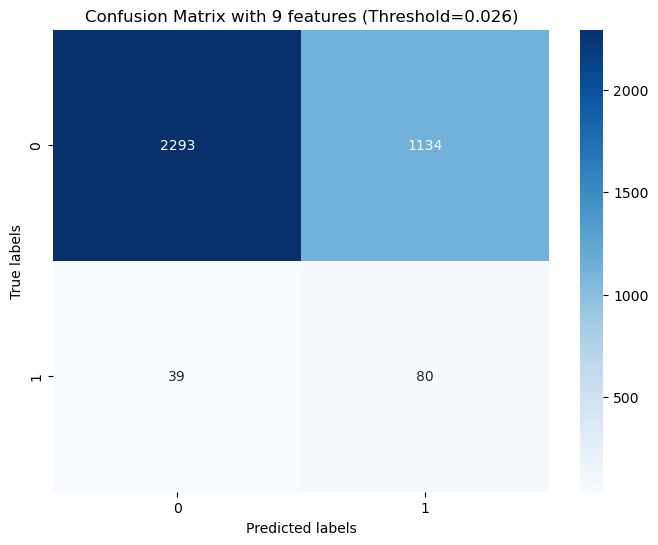

Features removed: ['const', 'Var3_woe', 'Var4_woe', 'working_months_1_woe', 'Var27_woe', 'ii_ratio_woe', 'Var8_q_woe', 'loan_desc_woe', 'Var26_q_woe', 'idi_ratio_woe']

Features included in the model: ['Var14_woe', 'Var5_woe', 'Var25_q_woe', 'Var12_woe', 'Var29_woe', 'income_woe', 'Var17_1_woe', 'Var28_woe', 'Var11_woe']



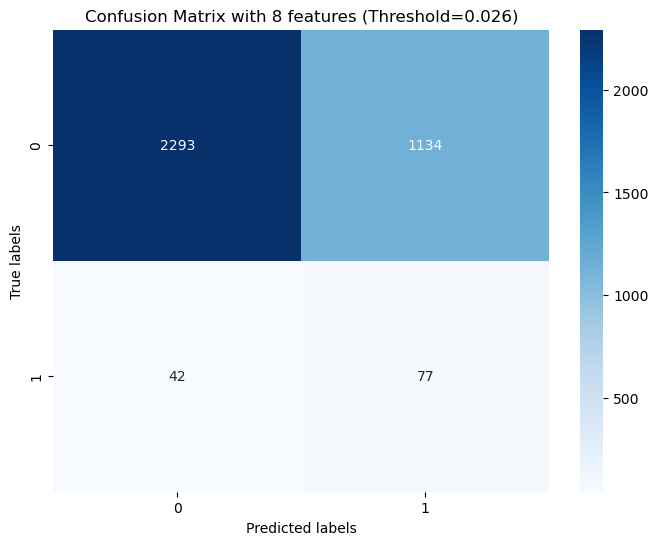

Features removed: ['const', 'Var3_woe', 'Var4_woe', 'working_months_1_woe', 'Var27_woe', 'ii_ratio_woe', 'Var8_q_woe', 'loan_desc_woe', 'Var26_q_woe', 'idi_ratio_woe', 'Var14_woe']

Features included in the model: ['Var5_woe', 'Var25_q_woe', 'Var12_woe', 'Var29_woe', 'income_woe', 'Var17_1_woe', 'Var28_woe', 'Var11_woe']



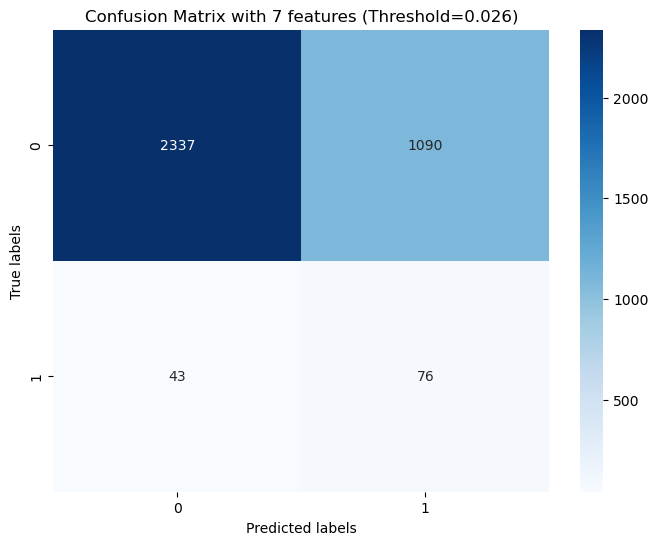

Features removed: ['const', 'Var3_woe', 'Var4_woe', 'working_months_1_woe', 'Var27_woe', 'ii_ratio_woe', 'Var8_q_woe', 'loan_desc_woe', 'Var26_q_woe', 'idi_ratio_woe', 'Var14_woe', 'Var5_woe']

Features included in the model: ['Var25_q_woe', 'Var12_woe', 'Var29_woe', 'income_woe', 'Var17_1_woe', 'Var28_woe', 'Var11_woe']



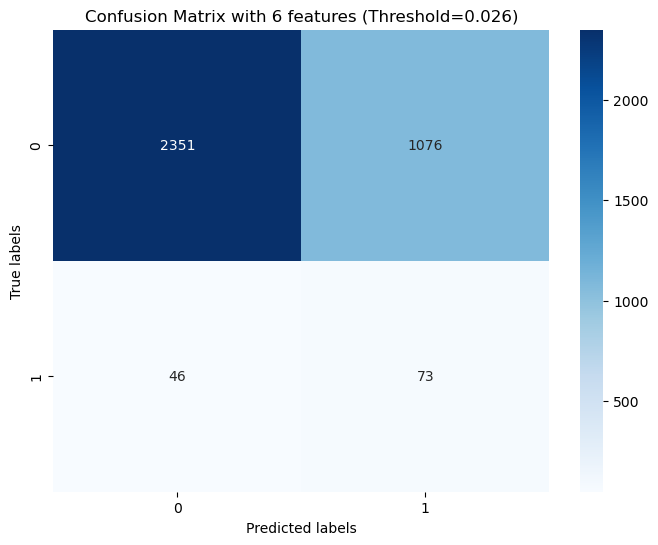

Features removed: ['const', 'Var3_woe', 'Var4_woe', 'working_months_1_woe', 'Var27_woe', 'ii_ratio_woe', 'Var8_q_woe', 'loan_desc_woe', 'Var26_q_woe', 'idi_ratio_woe', 'Var14_woe', 'Var5_woe', 'Var25_q_woe']

Features included in the model: ['Var12_woe', 'Var29_woe', 'income_woe', 'Var17_1_woe', 'Var28_woe', 'Var11_woe']



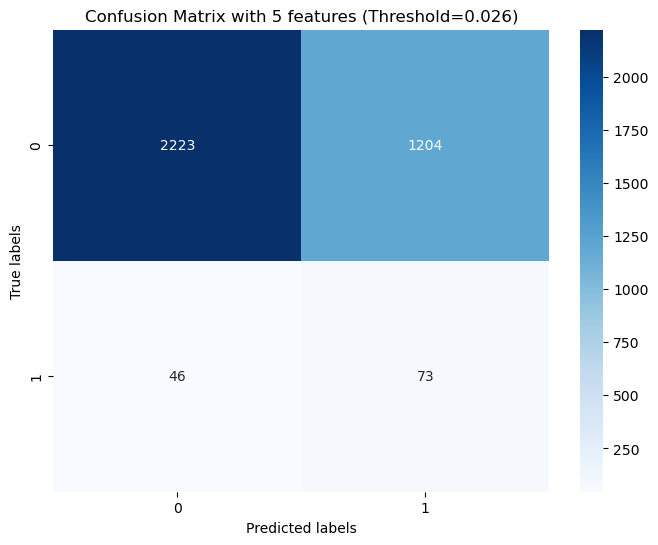

Features removed: ['const', 'Var3_woe', 'Var4_woe', 'working_months_1_woe', 'Var27_woe', 'ii_ratio_woe', 'Var8_q_woe', 'loan_desc_woe', 'Var26_q_woe', 'idi_ratio_woe', 'Var14_woe', 'Var5_woe', 'Var25_q_woe', 'Var12_woe']

Features included in the model: ['Var29_woe', 'income_woe', 'Var17_1_woe', 'Var28_woe', 'Var11_woe']



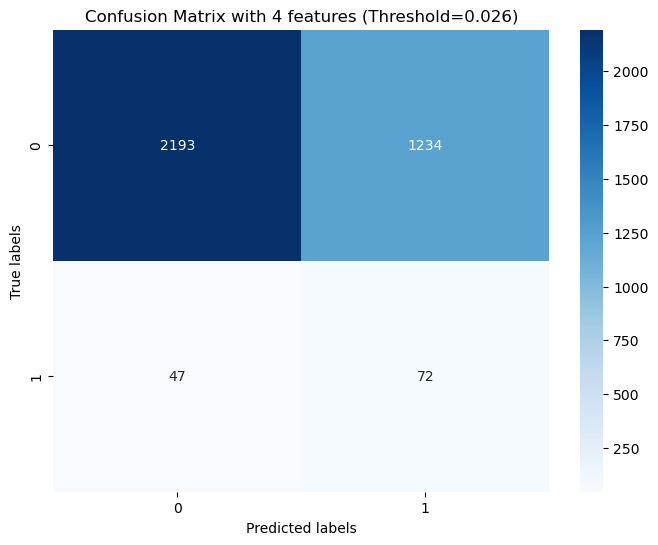

Features removed: ['const', 'Var3_woe', 'Var4_woe', 'working_months_1_woe', 'Var27_woe', 'ii_ratio_woe', 'Var8_q_woe', 'loan_desc_woe', 'Var26_q_woe', 'idi_ratio_woe', 'Var14_woe', 'Var5_woe', 'Var25_q_woe', 'Var12_woe', 'Var29_woe']

Features included in the model: ['income_woe', 'Var17_1_woe', 'Var28_woe', 'Var11_woe']



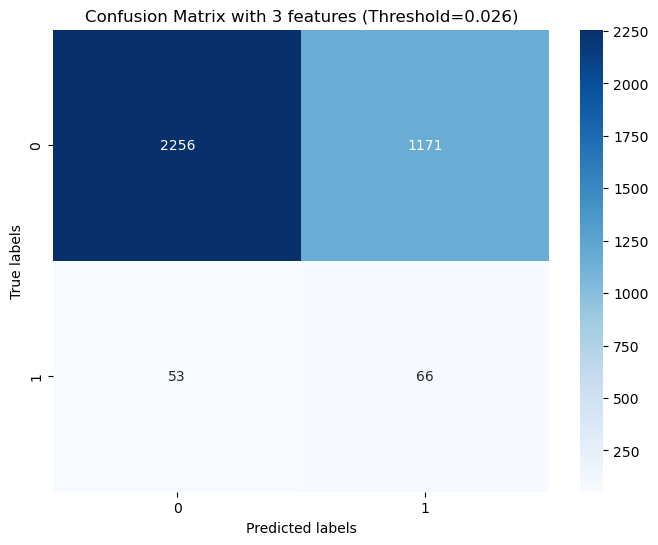

Features removed: ['const', 'Var3_woe', 'Var4_woe', 'working_months_1_woe', 'Var27_woe', 'ii_ratio_woe', 'Var8_q_woe', 'loan_desc_woe', 'Var26_q_woe', 'idi_ratio_woe', 'Var14_woe', 'Var5_woe', 'Var25_q_woe', 'Var12_woe', 'Var29_woe', 'income_woe']

Features included in the model: ['Var17_1_woe', 'Var28_woe', 'Var11_woe']



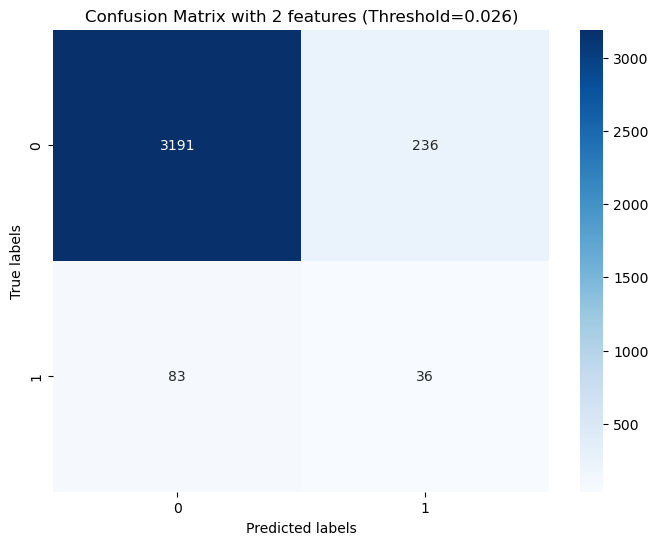

Features removed: ['const', 'Var3_woe', 'Var4_woe', 'working_months_1_woe', 'Var27_woe', 'ii_ratio_woe', 'Var8_q_woe', 'loan_desc_woe', 'Var26_q_woe', 'idi_ratio_woe', 'Var14_woe', 'Var5_woe', 'Var25_q_woe', 'Var12_woe', 'Var29_woe', 'income_woe', 'Var17_1_woe']

Features included in the model: ['Var28_woe', 'Var11_woe']



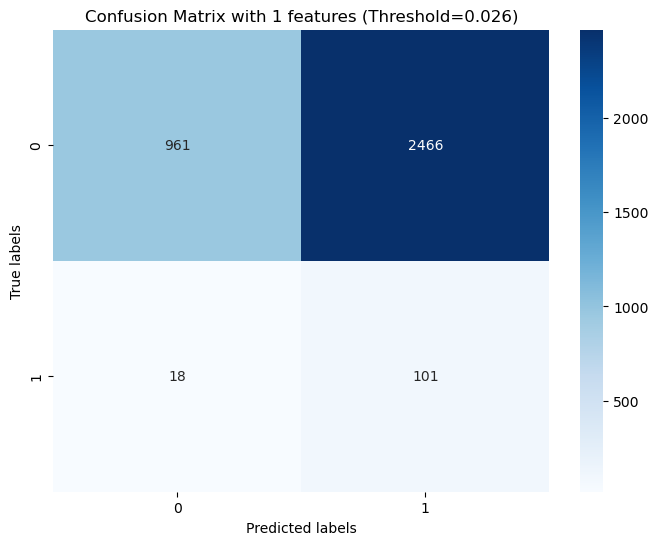

Features removed: ['const', 'Var3_woe', 'Var4_woe', 'working_months_1_woe', 'Var27_woe', 'ii_ratio_woe', 'Var8_q_woe', 'loan_desc_woe', 'Var26_q_woe', 'idi_ratio_woe', 'Var14_woe', 'Var5_woe', 'Var25_q_woe', 'Var12_woe', 'Var29_woe', 'income_woe', 'Var17_1_woe', 'Var28_woe']

Features included in the model: ['Var11_woe']



In [27]:
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Ustawienie progu
threshold = 0.026

# Przygotowanie listy nazw cech
feature_names = X_train_sm.columns.tolist()

# Ranking RFE, przykładowy ranking
ranking_rfe = [18, 0, 5, 8, 2, 6, 10, 14, 1, 4, 17, 16, 7, 12, 9, 13, 3, 11, 15]

# Sortowanie cech zgodnie z rankingiem RFE
# Najpierw tworzymy parę (nazwa_cechy, ranking) dla każdej cechy
features_with_ranking = zip(feature_names, ranking_rfe)

# Następnie sortujemy te pary według rankingu, od najwyższego do najniższego
sorted_features = sorted(features_with_ranking, key=lambda x: x[1], reverse=True)

# Wyciągamy posortowane nazwy cech
sorted_feature_names = [feature for feature, rank in sorted_features]

# Iteracyjne usuwanie cech i trenowanie modelu
for i in range(len(sorted_feature_names), 0, -1):
    # Wybieranie cech do włączenia do modelu, pomijając i najmniej ważnych cech (od końca listy)
    selected_features = sorted_feature_names[-i:]
    
    # Przygotowanie danych z wybranymi cechami
    X_train_selected = X_train_sm[selected_features]
    X_test_selected = X_test_sm[selected_features]
    
    # Dodanie stałej do modelu po wybraniu cech
    X_train_selected_with_const = sm.add_constant(X_train_selected)
    X_test_selected_with_const = sm.add_constant(X_test_selected)
    
    # Trenowanie modelu
    model = sm.Logit(y_train_sm, X_train_selected_with_const).fit(disp=0)
    
    # Predykcja na danych testowych
    y_pred_prob = model.predict(X_test_selected_with_const)
    y_pred = (y_pred_prob >= threshold).astype(int)
    
    # Obliczanie macierzy pomyłek
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Wyświetlanie macierzy pomyłek
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix with {len(selected_features)} features (Threshold={threshold})')
    plt.show()
    
    # Drukowanie listy usuniętych i włączonych cech dla jasności
    print(f"Features removed: {sorted_feature_names[:len(sorted_feature_names)-i]}\n")
    print(f"Features included in the model: {selected_features}\n")


Due to difficulties with choosing the best model, we should use the proper algorithm. The code with implementation is posted below

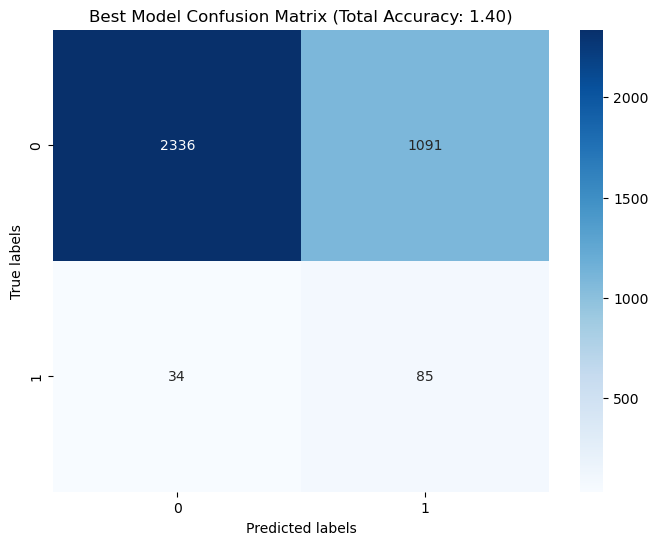

Best model uses 12 features: ['loan_desc_woe', 'Var26_q_woe', 'idi_ratio_woe', 'Var14_woe', 'Var5_woe', 'Var25_q_woe', 'Var12_woe', 'Var29_woe', 'income_woe', 'Var17_1_woe', 'Var28_woe', 'Var11_woe']
Features removed: {'Var27_woe', 'Var4_woe', 'Var8_q_woe', 'const', 'ii_ratio_woe', 'working_months_1_woe', 'Var3_woe'}



In [28]:
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ustawienie progu
threshold = 0.026

# Przygotowanie listy nazw cech
feature_names = X_train_sm.columns.tolist()

# Przykładowy ranking RFE
ranking_rfe = [18, 0, 5, 8, 2, 6, 10, 14, 1, 4, 17, 16, 7, 12, 9, 13, 3, 11, 15]

# Sortowanie cech zgodnie z rankingiem RFE
sorted_features = [feature for feature, rank in sorted(zip(feature_names, ranking_rfe), key=lambda x: x[1], reverse=True)]

best_score = 0
best_model_info = {}

for i in range(len(sorted_features), 0, -1):
    # Wybieranie cech do włączenia do modelu
    selected_features = sorted_features[-i:]
    
    # Przygotowanie danych z wybranymi cechami
    X_train_selected = X_train_sm[selected_features]
    X_test_selected = X_test_sm[selected_features]
    
    # Dodanie stałej do modelu po wybraniu cech
    X_train_selected_with_const = sm.add_constant(X_train_selected)
    X_test_selected_with_const = sm.add_constant(X_test_selected)
    
    # Trenowanie modelu
    model = sm.Logit(y_train_sm, X_train_selected_with_const).fit(disp=0)
    
    # Predykcja na danych testowych
    y_pred_prob = model.predict(X_test_selected_with_const)
    y_pred = (y_pred_prob >= threshold).astype(int)
    
    # Obliczanie macierzy pomyłek
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Obliczanie dokładności dla obu klas i ich sumy
    accuracy_0 = conf_matrix[0, 0] / np.sum(conf_matrix[0])
    accuracy_1 = conf_matrix[1, 1] / np.sum(conf_matrix[1])
    total_accuracy = accuracy_0 + accuracy_1
    
    # Aktualizacja najlepszego modelu, jeśli aktualna dokładność jest lepsza
    if total_accuracy > best_score:
        best_score = total_accuracy
        best_model_info = {
            'model': model,
            'selected_features': selected_features,
            'conf_matrix': conf_matrix,
            'total_accuracy': total_accuracy
        }

# Wyświetlenie najlepszego modelu
plt.figure(figsize=(8, 6))
sns.heatmap(best_model_info['conf_matrix'], annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title(f'Best Model Confusion Matrix (Total Accuracy: {best_model_info["total_accuracy"]:.2f})')
plt.show()

print(f"Best model uses {len(best_model_info['selected_features'])} features: {best_model_info['selected_features']}")
print(f"Features removed: {set(feature_names) - set(best_model_info['selected_features'])}\n")


Below there is the best logit model optimized by the highest possible sum of these outputs (TRUE POSITIVE + TRUE NEGATIVE)

                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                35700
Model:                          Logit   Df Residuals:                    35687
Method:                           MLE   Df Model:                           12
Date:                Thu, 14 Mar 2024   Pseudo R-squ.:                  0.1537
Time:                        19:51:10   Log-Likelihood:                -4158.7
converged:                       True   LL-Null:                       -4914.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            11.8647      0.502     23.631      0.000      10.881      12.849
loan_desc_woe    -0.7222      0.109     -6.608      0.000      -0.936      -0.508
Var26_q_woe      -0.7368      0.103     

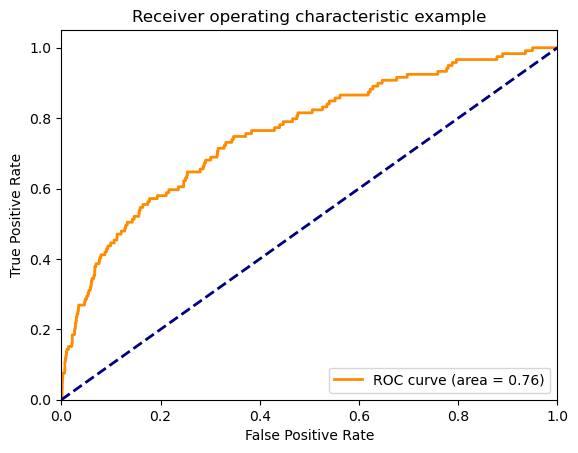

In [29]:
from sklearn.metrics import roc_curve, auc
import numpy as np
# Wyświetlenie podsumowania najlepszego modelu
print(best_model_info['model'].summary())

# Obliczanie wartości dla krzywej AUC-ROC
y_pred_prob = best_model_info['model'].predict(sm.add_constant(X_test_sm[best_model_info['selected_features']]))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Rysowanie krzywej AUC-ROC
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

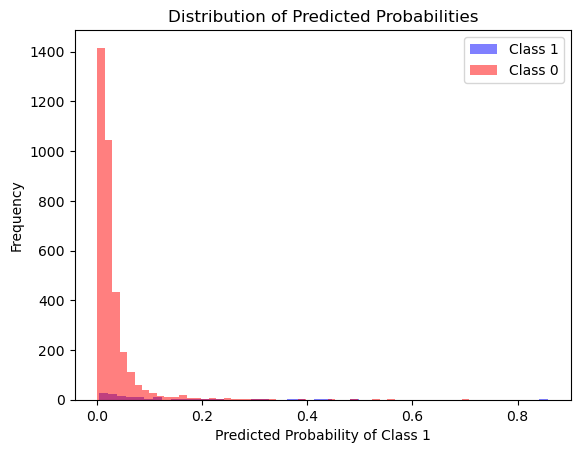

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Przykład rzeczywistych wartości y_test i przewidzianych prawdopodobieństw y_pred_prob
# y_test = np.array([...])  # rzeczywiste wartości Y
# y_pred_prob = np.array([...])  # prawdopodobieństwa przynależności do klasy 1

# Wykres dystrybucji prawdopodobieństw dla obu klas
plt.hist(y_pred_prob[y_test == 1], bins=50, color='blue', alpha=0.5, label='Class 1')
plt.hist(y_pred_prob[y_test == 0], bins=50, color='red', alpha=0.5, label='Class 0')

plt.xlabel('Predicted Probability of Class 1')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')
plt.legend()
plt.show()



